# Crime Data Exploratory Data Analysis

## 1 Problem Definition

**Problem Statement**
<br>Crime data for years 2012 until 2016 from Atlanta Police Department (APD) is provided. Explore the data set and visualize the findings. Build a prediction model using the 2012-2014 data and predict number of crimes in 2015-2016.   

**Useful Features**
1. occur_date: crime date
2. occur_time: crime time
3. location: location of crime (street address)
4. shift: work shift, e.g. evening, morning, day
5. UC2 Literal: crime type, e.g. AGG ASSAULT
6. neighborhood: geographical neighborhood e.g. downtown
7. x, y: longitude and latitude coordinates

**Target**
1. Exploratory data analysis and visualization
2. Model to predict number of crimes in 2015-2016 


## 2 Data Overview

### 2.1 Load Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as mn
import folium
from folium import plugins

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from xgboost import XGBRegressor

import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

### 2.2 Load Data

In [2]:
dfs = {}
for year in range(2012, 2017):
    dfs[str(year)] = pd.read_excel("./data/apd/COBRA-YTD{}.xlsx".format(year), sheet_name='CRIME_DATA')

##### Having confirmed that all data sets have the same header (features), merge them together for a whole dataframe.

In [3]:
df2012, df2013, df2014, df2015, df2016 = dfs.values()

In [4]:
# one dateframe with crimes from 2012 to 2016
df = pd.concat(dfs.values(), ignore_index=True)

In [5]:
df.shape

(156152, 23)

In [6]:
pd.set_option('display.max_columns', None)
df.head()

MI_PRINX  offense_id    rpt_date  occur_date occur_time   poss_date  \
0   1237192   110171050  01/17/2012  01/14/2012   03:00:00  01/14/2012   
1   1237283   110181057  01/17/2012  08/22/2011   12:00:00  08/22/2011   
2   1254718   112032439  03/08/2012  07/22/2011   15:00:00  07/22/2011   
3   1256108   112152334  03/13/2012  08/03/2011   12:00:00  08/03/2011   
4   1269411   113491709  01/04/2012  12/07/2011   14:00:00  12/07/2011   

  poss_time   beat apt_office_prefix apt_office_num  \
0  08:30:00  505.0               NaN            NaN   
1  14:00:00  508.0               NaN            NaN   
2  23:00:00  507.0               NaN            NaN   
3  18:00:00  104.0               NaN            NaN   
4  17:00:00  203.0               NaN            NaN   

                     location  MinOfucr MinOfibr_code dispo_code  \
0        659 PEACHTREE STREET       670          2308        NaN   
1     255 COURTLAND STREET NE       670          2308        NaN   
2            554 PIEDMONT AVE       720          2424        NaN   
3           2300 CARVER DR NW       710          2404        NaN   
4  1480 CHATTAHOOCHEE AVE. NW       640          2305        NaN   

   MaxOfnum_victims Shift Avg Day  loc_type           UC2 Literal  \
0               1.0  Morn     Sat      14.0   LARCENY-NON VEHICLE   
1               1.0   Day     Mon      14.0   LARCENY-NON VEHICLE   
2               1.0   Eve     Fri      13.0            AUTO THEFT   
3               1.0   Eve     Wed      20.0            AUTO THEFT   
4               1.0   Eve     Wed      18.0  LARCENY-FROM VEHICLE   

       neighborhood npu         x         y  
0      Sweet Auburn   M -84.37626  33.75427  
1  Glenrose Heights   Z -84.38301  33.66499  
2          Downtown   M -84.38232  33.76967  
3         Perkerson   X -84.41171  33.69205  
4        Hills Park   D -84.43610  33.80809

In [7]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156152 entries, 0 to 156151
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MI_PRINX           156152 non-null  int64  
 1   offense_id         156152 non-null  int64  
 2   rpt_date           156152 non-null  object 
 3   occur_date         156152 non-null  object 
 4   occur_time         156021 non-null  object 
 5   poss_date          156149 non-null  object 
 6   poss_time          156091 non-null  object 
 7   beat               156151 non-null  float64
 8   apt_office_prefix  4951 non-null    object 
 9   apt_office_num     31292 non-null   object 
 10  location           156150 non-null  object 
 11  MinOfucr           156152 non-null  int64  
 12  MinOfibr_code      156143 non-null  object 
 13  dispo_code         13635 non-null   object 
 14  MaxOfnum_victims   155694 non-null  float64
 15  Shift              156152 non-null  object 
 16  Av

MI_PRINX    offense_id           beat       MinOfucr  \
count  1.561520e+05  1.561520e+05  156151.000000  156152.000000   
mean   4.022864e+06  5.574660e+08     359.771388     592.045648   
std    3.455661e+06  7.728352e+09     170.282613     116.520676   
min    1.237192e+06  1.101710e+08     101.000000     110.000000   
25%    1.309919e+06  1.306825e+08     208.000000     511.000000   
50%    1.348958e+06  1.416219e+08     401.000000     640.000000   
75%    8.430218e+06  1.525101e+08     506.000000     670.000000   
max    8.493449e+06  1.636606e+11     902.000000     730.000000   

       MaxOfnum_victims       loc_type              x              y  
count     155694.000000  140018.000000  156152.000000  156152.000000  
mean           1.163648      21.070827     -84.045468      33.610701  
std            0.652146      16.406625       5.521462       2.208488  
min            0.000000       1.000000     -84.550500       0.000000  
25%            1.000000      13.000000     -84.432760      33.728020  
50%            1.000000      18.000000     -84.397560      33.755530  
75%            1.000000      21.000000     -84.373870      33.781040  
max           44.000000      99.000000       0.000000      33.886130

### 2.3 Missing Values

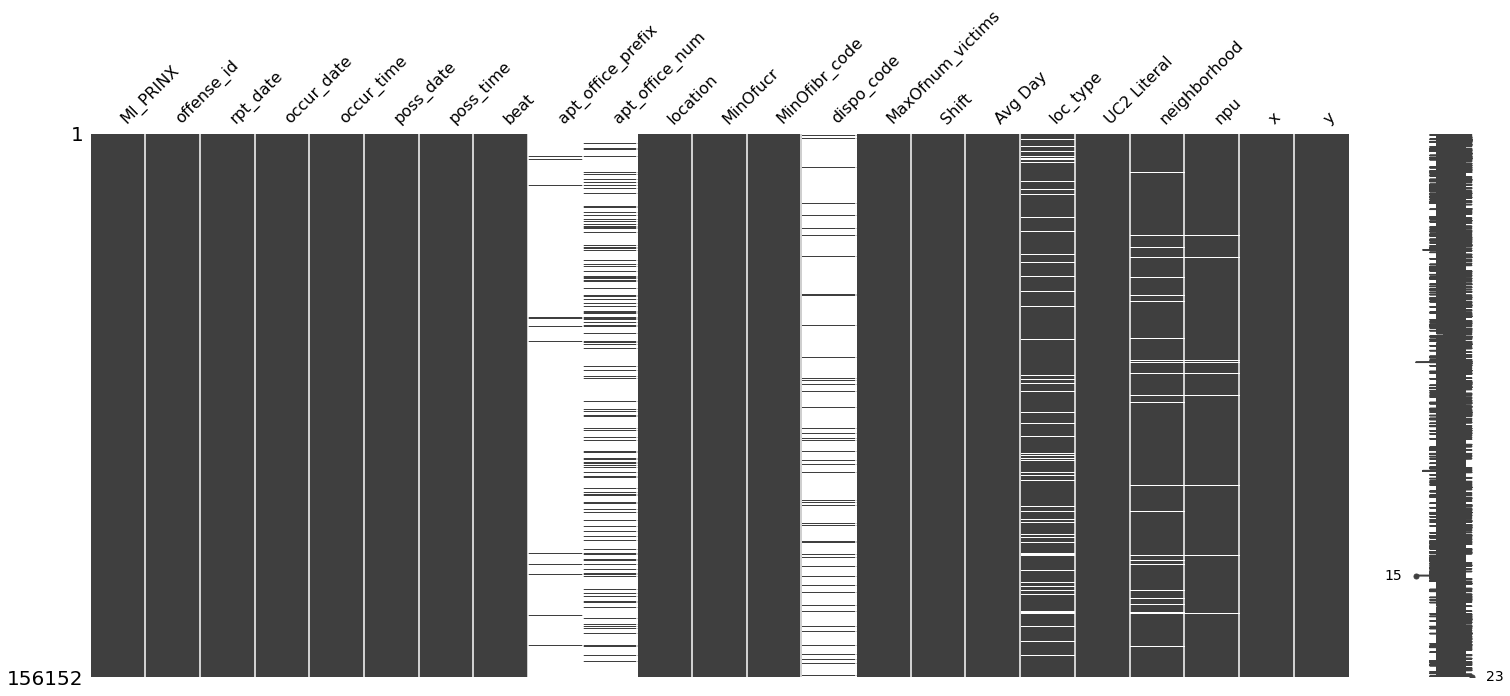

In [8]:
# overview of missing data
mn.matrix(df)
plt.show()

In [9]:
# missing data pecentage 
def missing(df):
    '''take a dataframe DF and return a summary of the missing data for each column'''
    total = df.isnull().sum()
    percent = df.isnull().sum()/df.isnull().count()
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).sort_values("Total", ascending=False)
    return missing_data

missing(df)[missing(df)['Total'] > 0]

Total   Percent
apt_office_prefix  151201  0.968294
dispo_code         142517  0.912681
apt_office_num     124860  0.799606
loc_type            16134  0.103322
neighborhood         7263  0.046512
npu                  1640  0.010503
MaxOfnum_victims      458  0.002933
occur_time            131  0.000839
poss_time              61  0.000391
MinOfibr_code           9  0.000058
poss_date               3  0.000019
location                2  0.000013
beat                    1  0.000006

## 3 Exploratory Data Analysis

### 3.1 occur_date

In [10]:
# helper function to build a occur_date dataframe
def make_df_date(df):
    '''Takes a dataframe DF, return a new dataframe DF_DATE with columns: year, month, day, weekday'''
    df_date = pd.DataFrame()
    date = pd.to_datetime(df['occur_date'])
    df_date['date'] = date
    df_date['year'] = date.dt.year
    df_date['month'] = date.dt.month
    df_date['day'] = date.dt.day
    df_date['weekday'] = date.dt.weekday + 1 # Monday=1, Sunday=7
    
    return df_date

def make_df_date_period(df):
    '''
    Takes a dataframe DF, return a new dataframe DF_DATE with columns: year, month, day, weekday.
    As well as "sin_" and "cos_" to take the periodic behavior into consideration.
    This can be useful for better model performance
    '''
    df_date = pd.DataFrame()
    date = pd.to_datetime(df['occur_date'])
    df_date['date'] = date
    df_date['year'] = date.dt.year
    df_date['month'] = date.dt.month
    df_date['day'] = date.dt.day
    df_date['weekday'] = date.dt.weekday + 1 # Monday=1, Sunday=7
    
    df_date["sin_month"] = df_date["month"].apply(lambda x: np.sin(2*np.pi*x/12))
    df_date["cos_month"] = df_date["month"].apply(lambda x: np.cos(2*np.pi*x/12))

    days_in_month = [pd.Period(str(day)).days_in_month for day in date]
    day_percent = df_date["day"] / days_in_month
    df_date["sin_day"] = day_percent.apply(lambda x: np.sin(2*np.pi*x))
    df_date["cos_day"] = day_percent.apply(lambda x: np.cos(2*np.pi*x))

    df_date["sin_weekday"] = df_date["weekday"].apply(lambda x: np.sin(2*np.pi*x/7))
    df_date["cos_weekday"] = df_date["weekday"].apply(lambda x: np.cos(2*np.pi*x/7))
    
    return df_date

In [11]:
# helper fucntion to plot the distribution
def period_count(df, period, year=None, crime='all crimes', order=None): 
    '''
    Count the number of crimes in dataframe DF and in frequency of PERIOD. Crime type is CRIME and x range is ORDER.
    Return a histogram plot.
    '''
    plt.figure(figsize=(15,5))
    if year:
        plt.title("Number of crimes occured in a particular {} in {} for {}.".format(period, year, crime))
    else:
        plt.title("Number of crimes occured in a particular {} for {}.".format(period, crime))
    sns.countplot(x=period, data=df, order=order)
    plt.show()

In [12]:
df_date = make_df_date(df)
df_date_period = make_df_date_period(df)

In [13]:
# date dataframes for different years
dfs_date = {}
for year in range(2012, 2017):
    dfs_date[str(year)] = make_df_date(dfs[str(year)])

In [14]:
df2012_date, df2013_date, df2014_date, df2015_date, df2016_date = dfs_date.values()

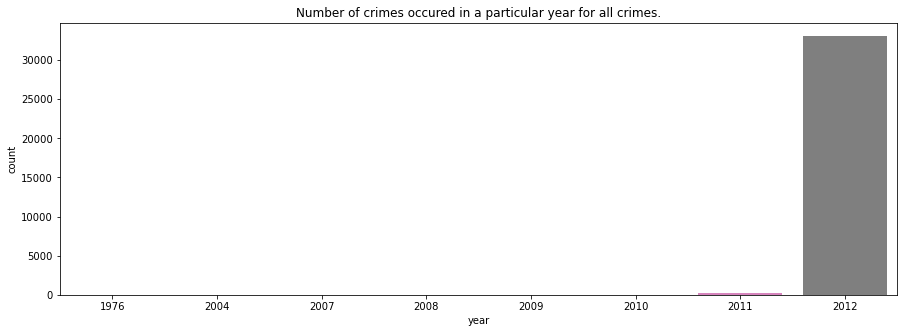

In [15]:
# number of crimes occured in different years while recorded in 2012
period_count(df2012_date, 'year')

##### I have checked other years. The crimes occured in a particular year is usually recorded in the same year, with only a few exceptions. In this work, I will ingore this delay in record for the sake of time.

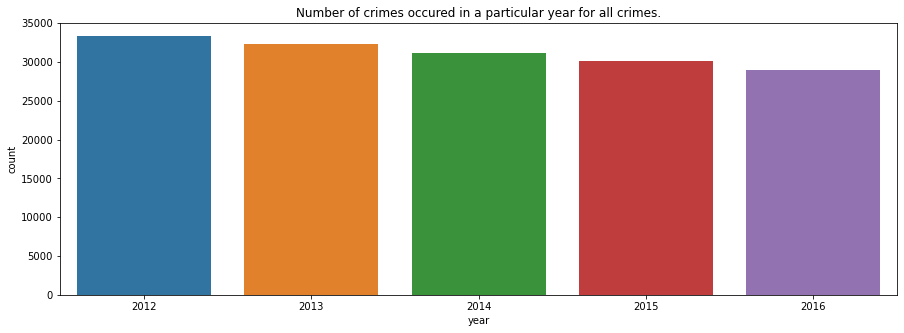

In [16]:
# number of all crimes from 2012 to 2016
period_count(df_date, 'year', order=range(2012,2017))

##### Generally, the number of crimes keeps decreasing over year, indicating Atlanta becomes safer and safer over time.

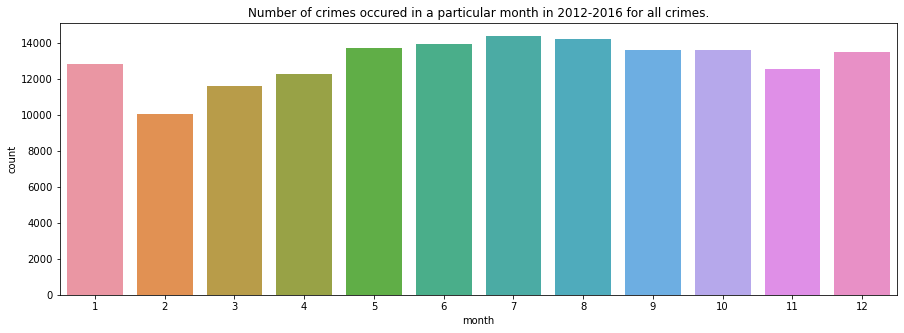

In [17]:
period_count(df_date, 'month', year='2012-2016')

##### There are more crimes in the middle (June to Aug.) and end (Dec. and Jan.) of the year, showing a seasonal behavior.

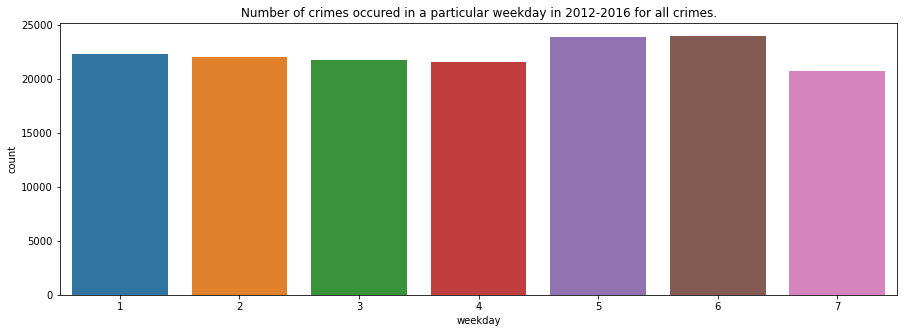

In [18]:
period_count(df_date, 'weekday', year='2012-2016')

##### There are more crimes on Friday and Saturday.

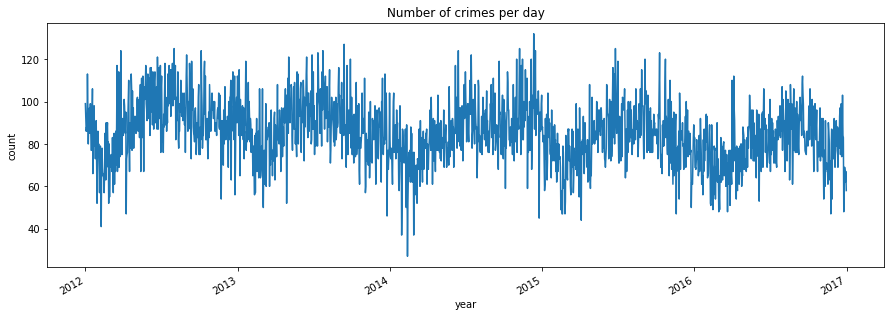

In [19]:
plt.figure(figsize=(15,5))
df_date['date'][df_date['year']>=2012].value_counts().plot()
plt.xlabel('year')
plt.ylabel('count')
plt.title('Number of crimes per day')
plt.show()

##### The number of crimes per day shows a seasonal behavior, consistent with the distribution plot over month.

### 3.2 occur_time

In [20]:
# helper function to build a occur_time dataframe
def make_df_time(df):
    '''Takes a dataframe DF, return a new dataframe DF_TIME with columns: hour, min_in_day'''
    df_time = pd.DataFrame()
    time = pd.to_datetime(df['occur_time'], format='%H:%M:%S') 
    df_time['hour'] = time.dt.hour
    df_time['min_in_day'] = time.dt.hour * 60 + time.dt.minute
    
    return df_time

def make_df_time_period(df):
    '''
    Takes a dataframe DF, return a new dataframe DF_TIME with columns: hour, min_in_day.
    As well as "sin_min" and "cos_min" to take the periodic behavior into consideration.
    This can be useful for better model performance
    '''
    df_time = pd.DataFrame()
    time = pd.to_datetime(df['occur_time'], format='%H:%M:%S') 
    df_time['hour'] = time.dt.hour
    df_time['min_in_day'] = time.dt.hour * 60 + time.dt.minute

    df_time["sin_min"] = df_time['min_in_day'].apply(lambda x: np.sin(2*np.pi*x/1440))
    df_time["cos_min"] = df_time['min_in_day'].apply(lambda x: np.cos(2*np.pi*x/1440))
    
    return df_time

In [21]:
df_time = make_df_time(df)
df_time_period = make_df_time_period(df)

In [22]:
# time dataframes for different years
dfs_time = {}
for year in range(2012, 2017):
    dfs_time[str(year)] = make_df_time(dfs[str(year)])

In [23]:
df2012_time, df2013_time, df2014_time, df2015_time, df2016_time = dfs_time.values()

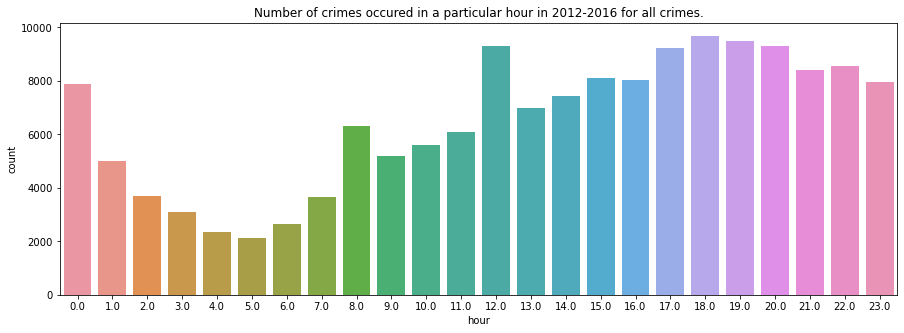

In [24]:
period_count(df_time, 'hour', year='2012-2016')

##### Overall, the most unsafe time in a day is at night from 5PM to 0AM. 8AM in the morning and 12PM at noon also have many crimes.

### 3.3 Shift

In [25]:
# helper function to plot the distribution
def count_plot(df, fea, year='2012-2016', crime='all crimes'):
    '''
    Count the number of crimes in dataframe DF for column FEA. Crime type is CRIME.
    Return a histogram plot. Only keeps the top 15 values in FEA.
    '''
    plt.figure(figsize=(15,5))
    t_df = pd.DataFrame(df[fea].value_counts(dropna=False)).reset_index().fillna('Unknown')
    t_df.columns = [fea, 'Count']
    sns.barplot(x=fea, y='Count', data=t_df.head(15))
    plt.xticks(rotation=60)
    plt.title(fea + ' distribution in {} for {}'.format(year, crime))
    plt.show()

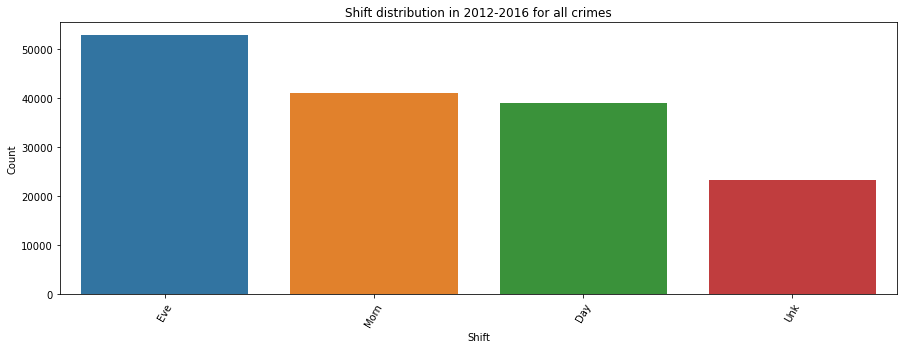

In [26]:
count_plot(df, 'Shift')

##### Most of the crimes happen at evening shift, consistent with the distribution in hour.

In [27]:
le = LabelEncoder()
le.fit_transform(df['Shift'].values.reshape(-1,1))

array([2, 0, 1, ..., 0, 1, 2])

In [28]:
# helper function to do label encoding
def label(df, fea):
    '''Label encode the column FEA in dataframe DF. Return a dataframe T_DF.'''
    le = LabelEncoder()
    res = le.fit_transform(df[fea].fillna('Unk'))
    t_df = pd.DataFrame(data={fea: res})
    return t_df

In [29]:
# label encode shift
df_shift = label(df, 'Shift')
df_shift.head()

Shift
0      2
1      0
2      1
3      1
4      1

### 3.4 neighborhood

In [30]:
df['neighborhood'].unique().shape

(242,)

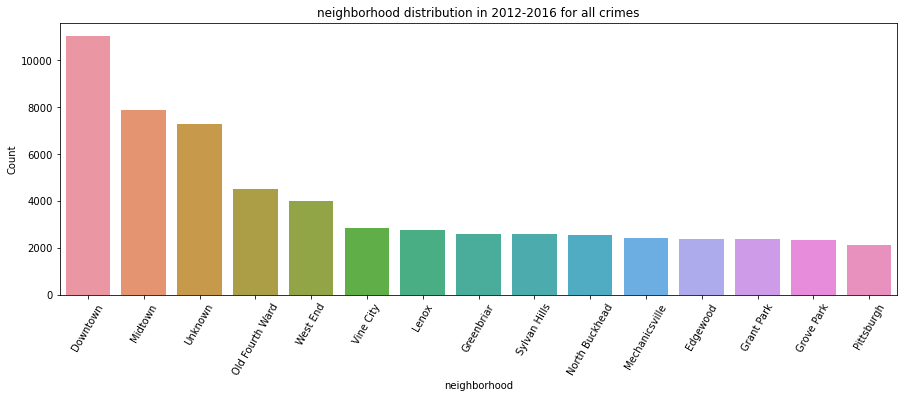

In [31]:
count_plot(df, 'neighborhood') # only top 15 neighborhoods are shown

##### Most dangerous neighborhoods are Downtown, Midtown, Old Fourth Ward, West End and some unknown area
##### Number of crimes at unknown area comparable to the top 2 neighborhoods. I will label these area as 'Unk_neighbor', instead of fill with the mode value

In [32]:
# label encode neighborhood
df_neighborhood = label(df, 'neighborhood')
df_neighborhood.head()

neighborhood
0           207
1           101
2            79
3           175
4           115

### 3.5 location

In [33]:
df['location'].unique().shape

(54975,)

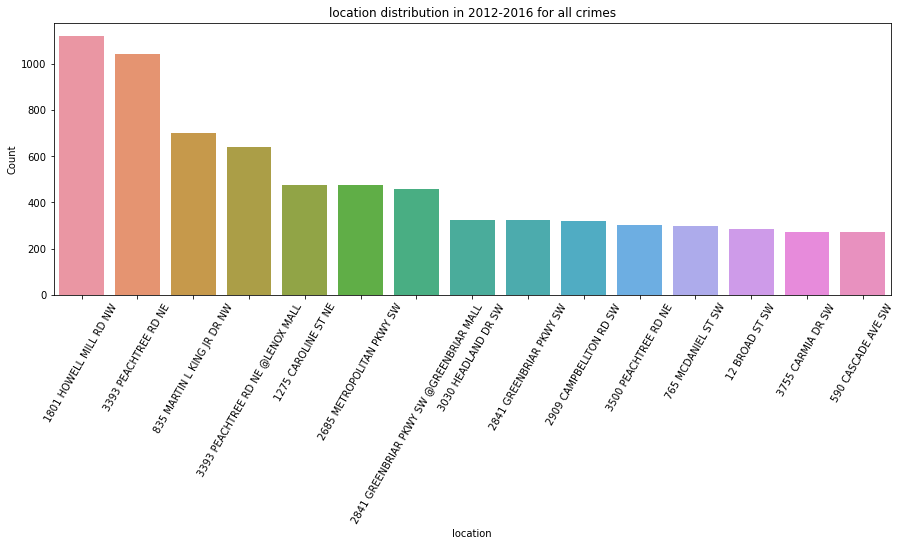

In [34]:
count_plot(df, 'location') # only top 15 locations are shown

In [35]:
df['location'].value_counts().head(5).index

Index(['1801 HOWELL MILL RD NW', '3393 PEACHTREE RD NE',
       '835 MARTIN L KING JR DR NW', '3393 PEACHTREE RD NE @LENOX MALL',
       '1275 CAROLINE ST NE'],
      dtype='object')

##### Most dangerous locations are 1801 HOWELL MILL RD NW, 3393 PEACHTREE RD NE, 835 MARTIN L KING JR DR NW, 3393 PEACHTREE RD NE @LENOX MALL

In [36]:
# label encode location
df_location = label(df, 'location')
df_location.head()

location
0     44029
1     24100
2     40873
3     21654
4     10100

### 3.6 UC2 Literal (crime type)

#### 3.6.1 all crimes

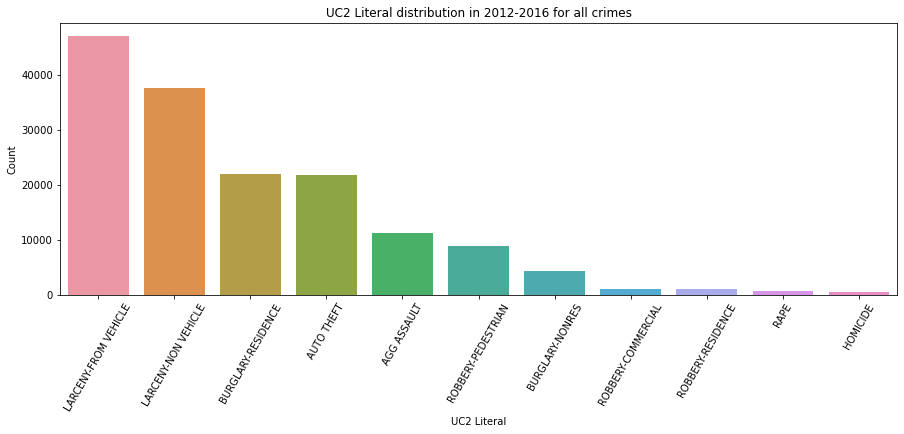

In [37]:
count_plot(df, 'UC2 Literal')

In [38]:
def hour_plots(df, fea='UC2 Literal'):
    fig = plt.figure(figsize=(15,15))
    ctypes = df[fea].value_counts().index
    for i, crime_type in enumerate(ctypes):
        ax = fig.add_subplot(int(np.ceil(float(len(ctypes)) / 3)), 3, i+1)
        df_crime = df.groupby(fea).get_group(crime_type)
        df_time = make_df_time(df_crime)
        sns.countplot(x='hour', data=df_time, ax=ax)
        ax.set_title(crime_type)
        ax.set_xticklabels(sorted(df_time['hour'].unique()), rotation=90)
    fig.tight_layout()
    plt.show()
    
def neighbor_plots(df, fea='UC2 Literal'):
    fig = plt.figure(figsize=(15,20))
    ctypes = df[fea].value_counts().index
    for i, crime_type in enumerate(ctypes):
        ax = fig.add_subplot(int(np.ceil(float(len(ctypes)) / 3)), 3, i+1)
        df_crime = df.groupby(fea).get_group(crime_type)
        t_df = pd.DataFrame(df_crime['neighborhood'].value_counts(dropna=False)).reset_index().fillna('Unknown')
        t_df.columns = ['neighborhood', 'Count']
        sns.barplot(x='neighborhood', y='Count', data=t_df.head(15))
        ax.set_xticklabels(t_df['neighborhood'], rotation=90)
        ax.set_title(crime_type)
    fig.tight_layout()
    plt.show()

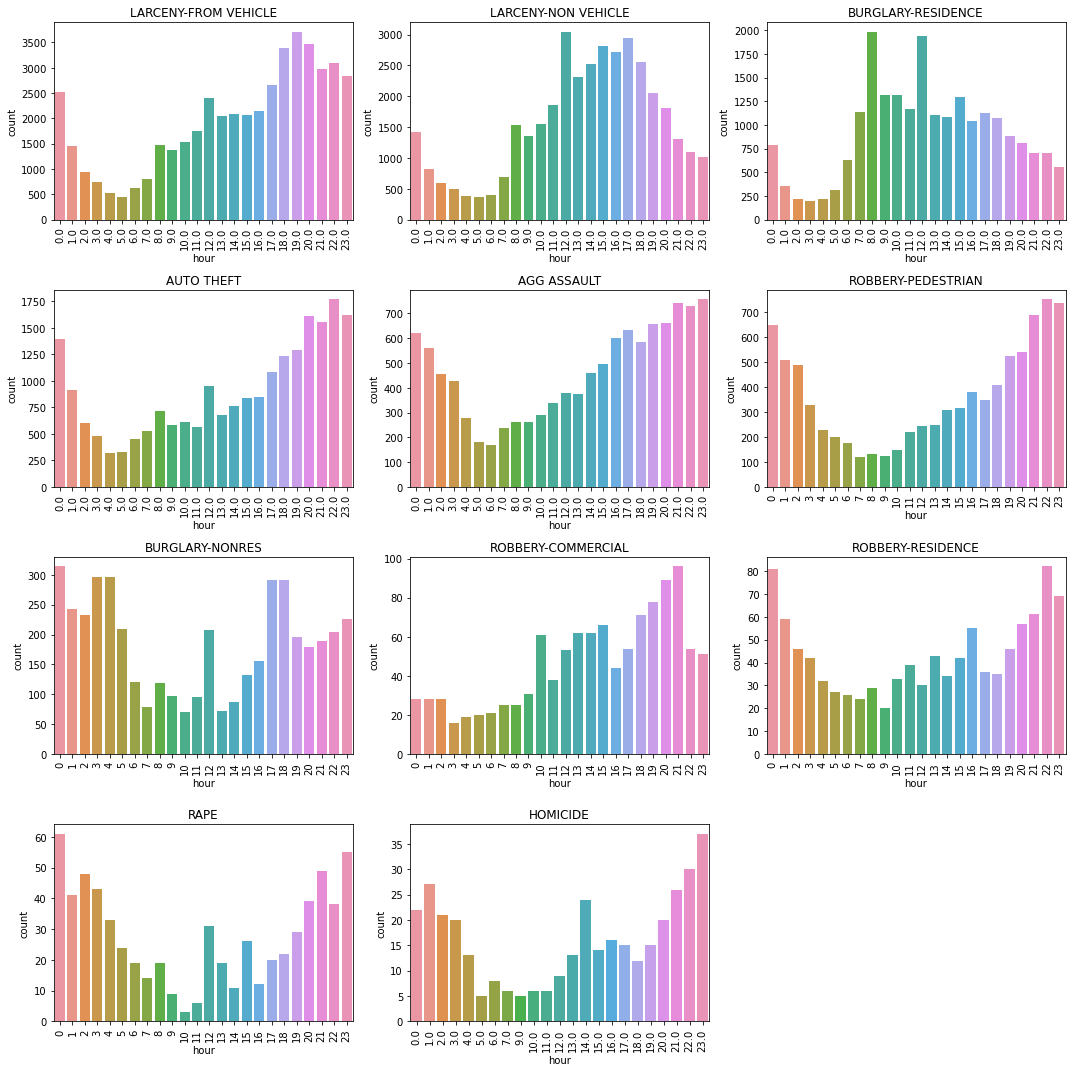

In [39]:
hour_plots(df)

###### The most likely time for each crime
1. LARCENY-FROM VEHICLE: 6-8pm
2. LARCENY-NON VEHICLE: 12pm, 3-5pm
3. BURGLARY-RESIDENCE: 8am, 12pm
4. AUTO THEFT: 8-11pm
5. AGG ASSAULT: 9-11pm
6. ROBBERY-PEDESTRIAN: 9-11pm
7. BURGLARY-NONRES: 0am, 3-4am, 12pm, 5-6pm
8. ROBBERY-COMMERCIAL: 7-9pm
9. ROBBERY-RESIDENCE: 10pm-1am
10. RAPE: 11pm-0am
11. HOMICIDE: 1am, 2pm, 10-11pm

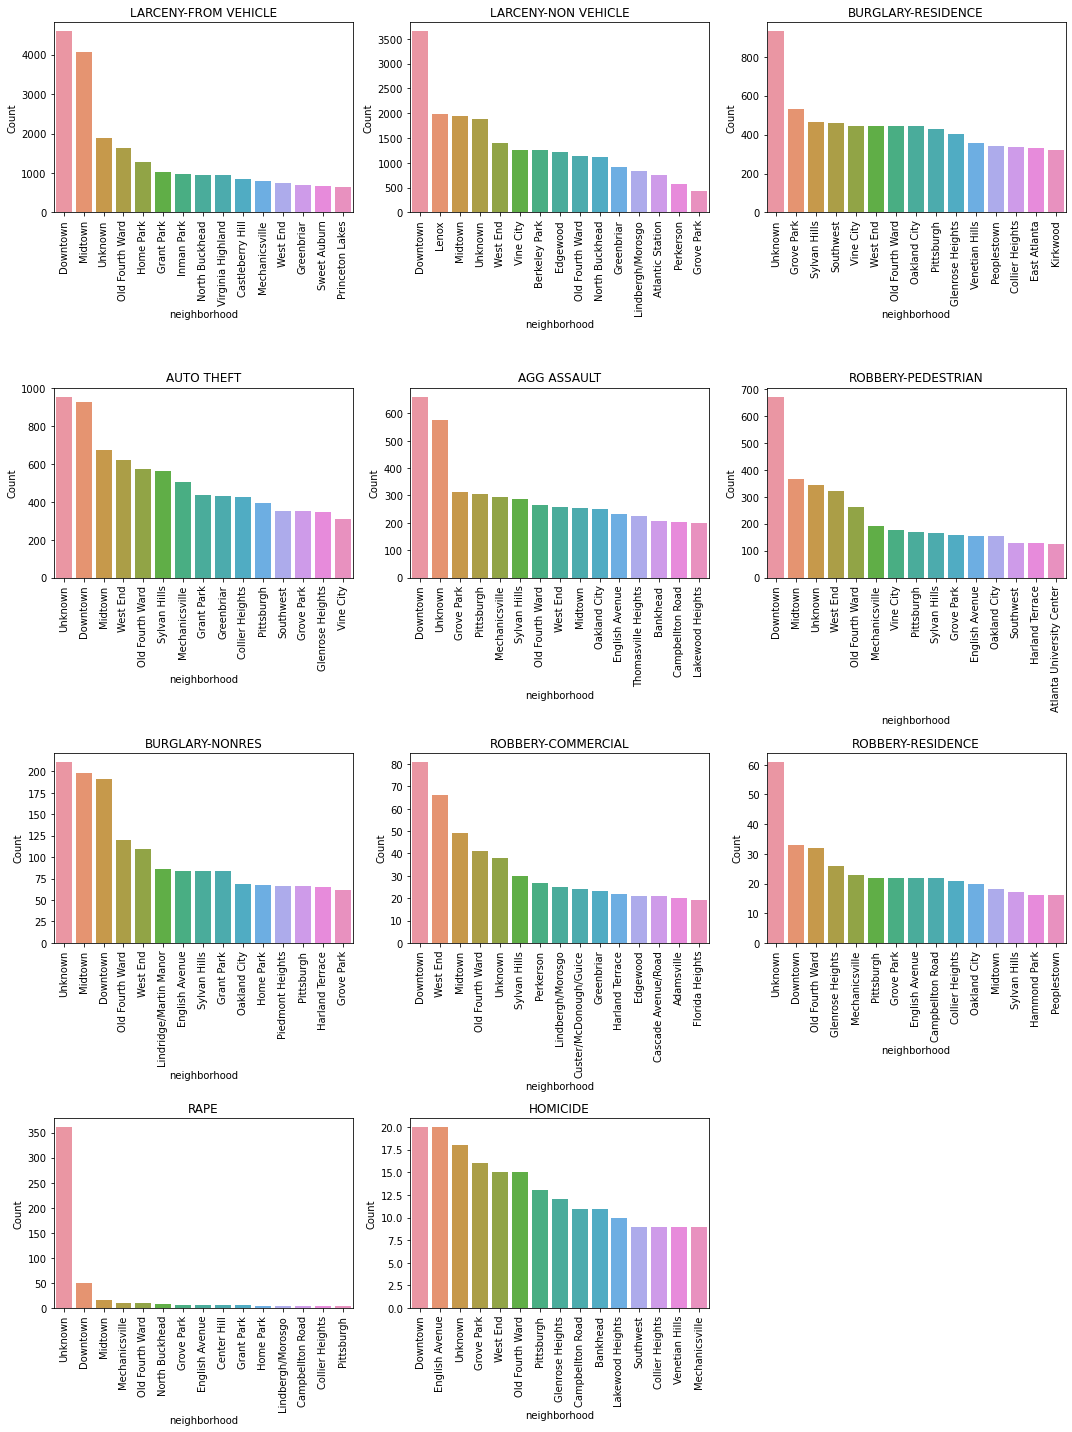

In [40]:
neighbor_plots(df)

###### The most likely neighborhood for each crime
1. LARCENY-FROM VEHICLE: Downtown, Midtown
2. LARCENY-NON VEHICLE: Downtown
3. BURGLARY-RESIDENCE: Grove Park
4. AUTO THEFT: Downtown
5. AGG ASSAULT: Downtown
6. ROBBERY-PEDESTRIAN: Downtown
7. BURGLARY-NONRES: Midtown, Downtown
8. ROBBERY-COMMERCIAL: Downtown, West End
9. ROBBERY-RESIDENCE: Downtow, Old Fourth Ward
10. RAPE: Downtown
11. HOMICIDE: Downtown, English Avenue

##### The top 5 most common crime types are: LARCENY-FROM VEHICLE, LARCENY-NON VEHICLE, BURGLARY-RESIDENCE, AUTO THEFT, and AGG ASSAULT. I will give more detailed analysis on these crimes in the following.

#### 3.6.2 LARCENY-FROM VEHICLE

In [41]:
# group the dataframe by crime type
g_crime_type = df.groupby('UC2 Literal')

In [42]:
df_LFV = g_crime_type.get_group('LARCENY-FROM VEHICLE')
df_LFV_date = make_df_date(df_LFV)
df_LFV_time = make_df_time(df_LFV)

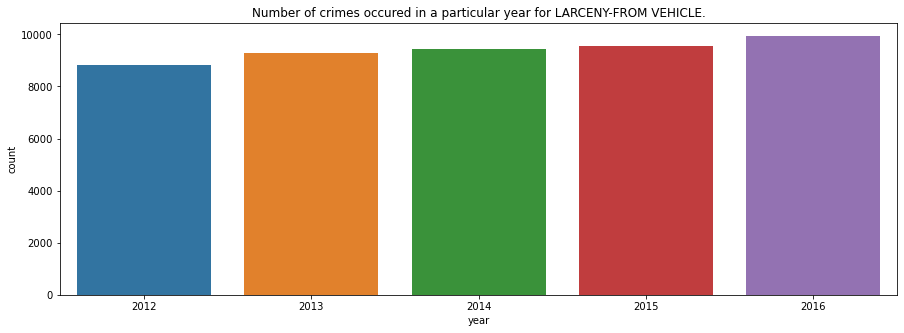

In [43]:
period_count(df_LFV_date, 'year', crime='LARCENY-FROM VEHICLE', order=range(2012,2017))

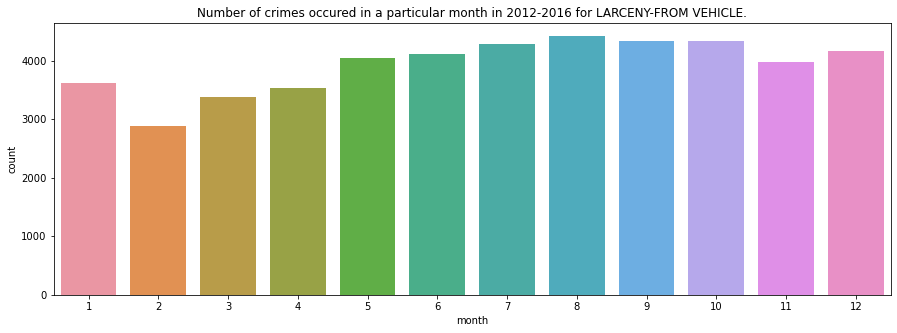

In [44]:
period_count(df_LFV_date, 'month', crime='LARCENY-FROM VEHICLE', year='2012-2016')

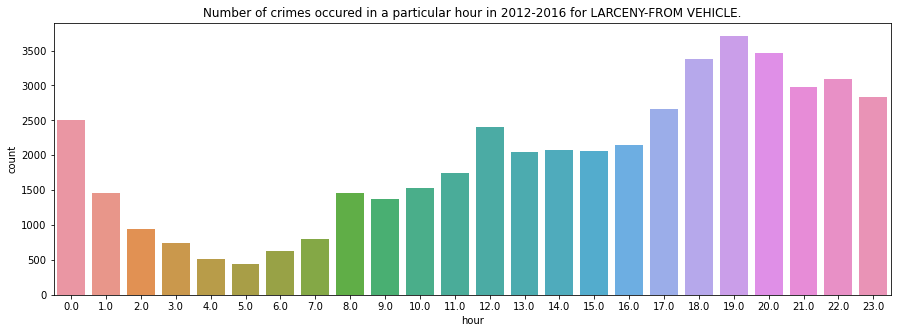

In [45]:
period_count(df_LFV_time, 'hour', crime='LARCENY-FROM VEHICLE', year='2012-2016')

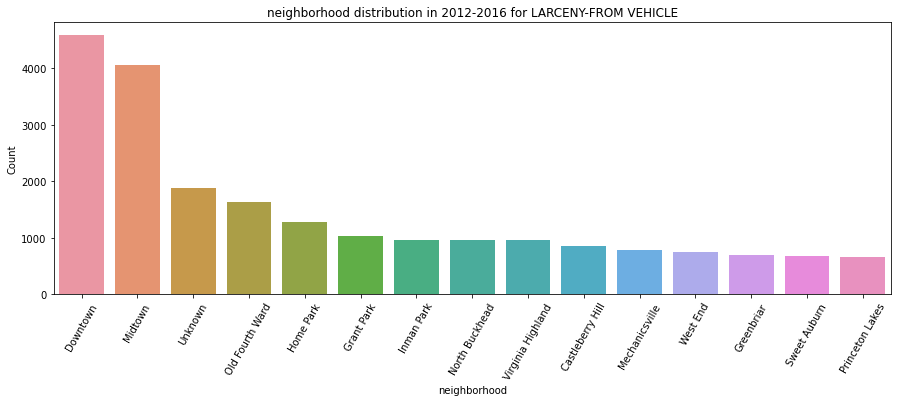

In [46]:
count_plot(df_LFV, 'neighborhood', crime='LARCENY-FROM VEHICLE')

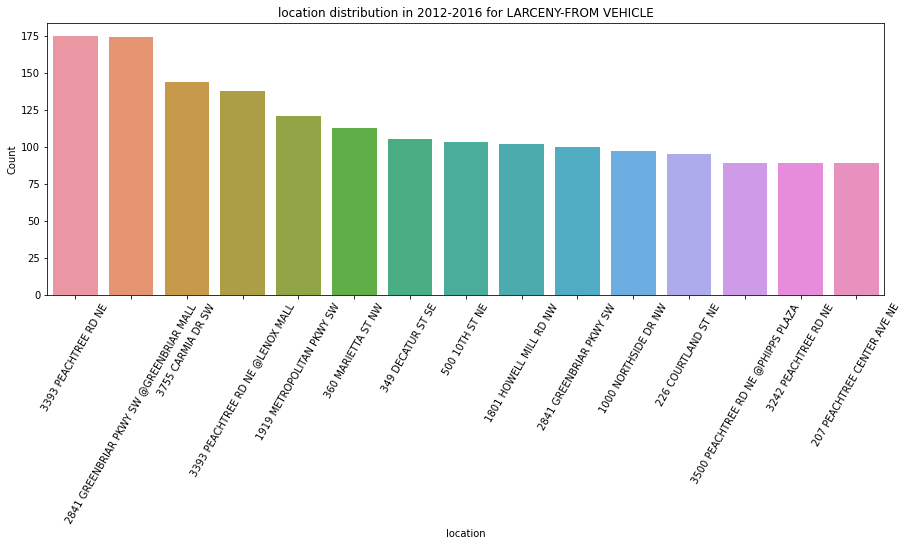

In [47]:
count_plot(df_LFV, 'location', crime='LARCENY-FROM VEHICLE')

##### LARCENY-FROM VEHICLE
1. Case keeps increasing from 2012 to 2016
2. Dangerous months are July to Oct.
3. Dangerous time are 5PM to 0AM at night, especially 7PM. Also need to be careful at noon
4. Dangerous neighborhoods are Downtown, Midtown, Old Fourth Ward, and some unknown area
5. Dangerous locations are 3393 PEACHTREE RD NE, 2841 GREENBRIAR PKWY SW @GREENBRIAR MALL, and 3755 CARMIA DR SW

#### 3.6.3 LARCENY-NON VEHICLE

In [48]:
df_LNV = g_crime_type.get_group('LARCENY-NON VEHICLE')
df_LNV_date = make_df_date(df_LNV)
df_LNV_time = make_df_time(df_LNV)

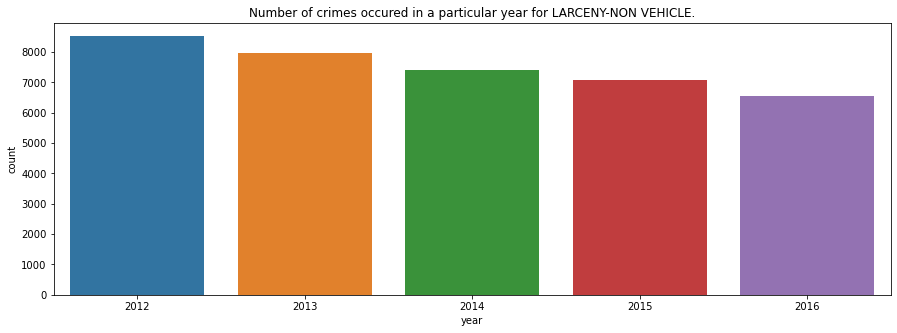

In [49]:
period_count(df_LNV_date, 'year', crime='LARCENY-NON VEHICLE', order=range(2012,2017))

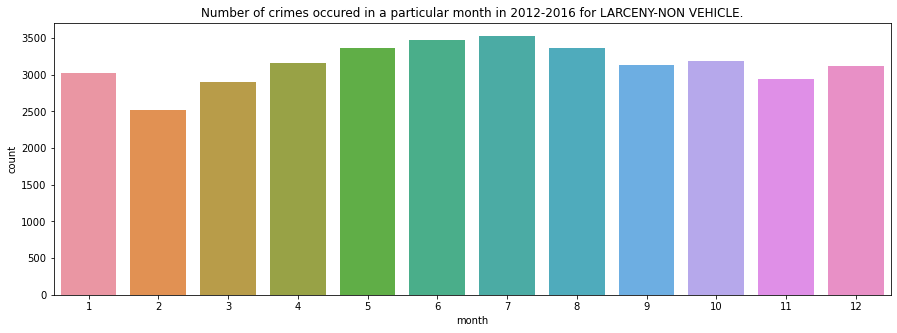

In [50]:
period_count(df_LNV_date, 'month', crime='LARCENY-NON VEHICLE', year='2012-2016')

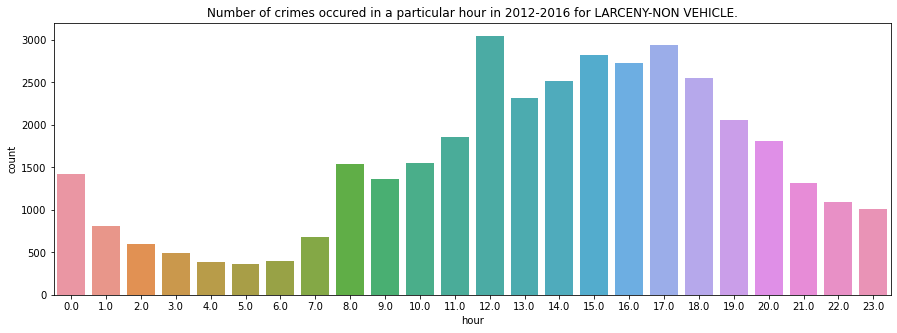

In [51]:
period_count(df_LNV_time, 'hour', crime='LARCENY-NON VEHICLE', year='2012-2016')

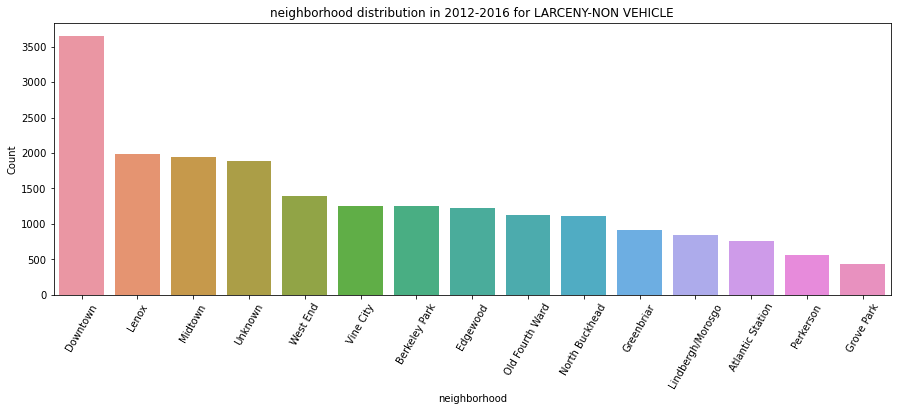

In [52]:
count_plot(df_LNV, 'neighborhood', crime='LARCENY-NON VEHICLE')

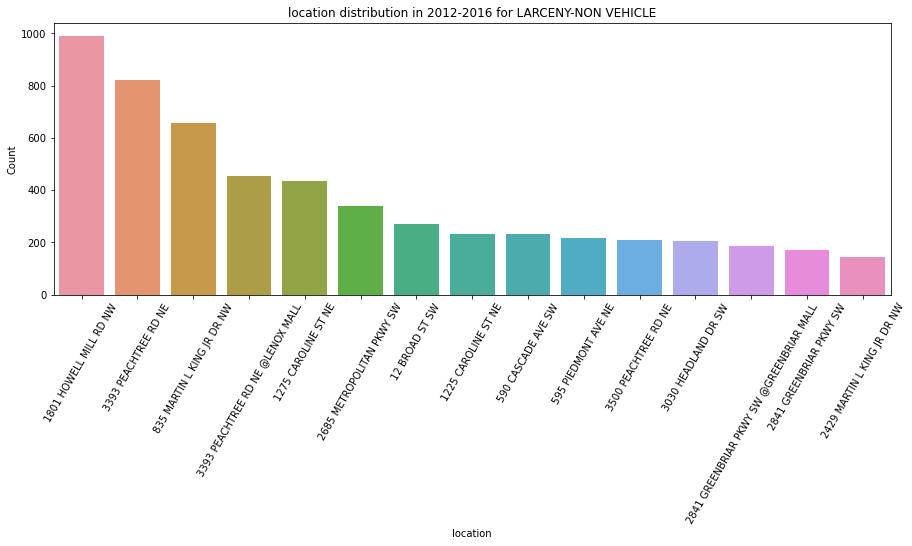

In [53]:
count_plot(df_LNV, 'location', crime='LARCENY-NON VEHICLE')

##### LARCENY-NON VEHICLE
1. Case keeps decreasing from 2012 to 2016
2. Dangerous months are May to Aug.
3. Dangerous time are 11AM to 8AM in the afternoon, especially 12PM and 5PM. Also need to be careful at 0AM and 8AM
4. Dangerous neighborhoods are Downtown, Lenox, and Midtown
5. Dangerous locations are 1801 HOWELL MILL RD NW, 3393 PEACHTREE RD NE, 835 MARTIN L KING JR DR NW

#### 3.6.4 BURGLARY-RESIDENCE

In [54]:
df_BR = g_crime_type.get_group('BURGLARY-RESIDENCE')
df_BR_date = make_df_date(df_BR)
df_BR_time = make_df_time(df_BR)

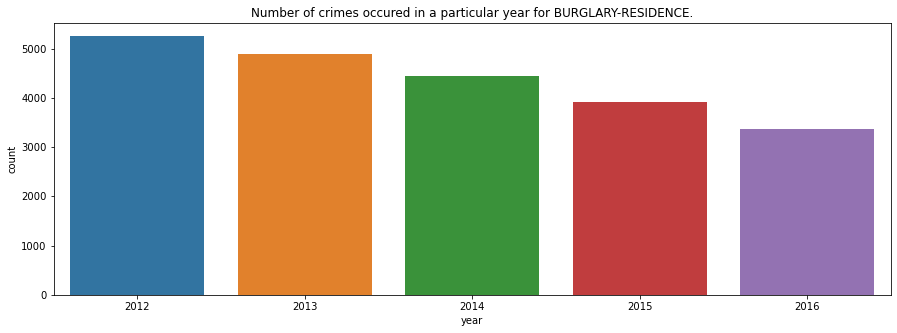

In [55]:
period_count(df_BR_date, 'year', crime='BURGLARY-RESIDENCE', order=range(2012,2017))

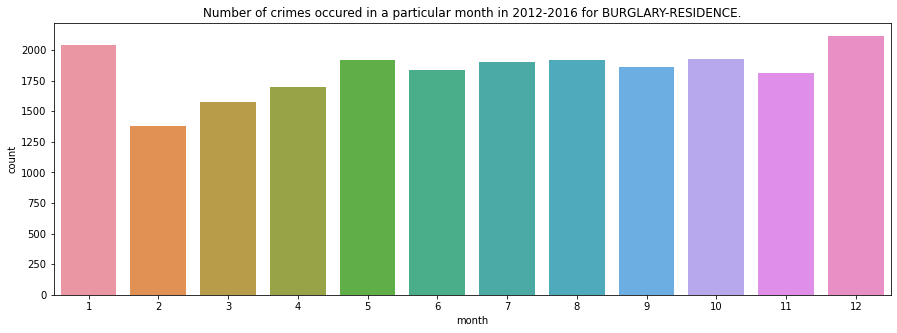

In [56]:
period_count(df_BR_date, 'month', crime='BURGLARY-RESIDENCE', year='2012-2016')

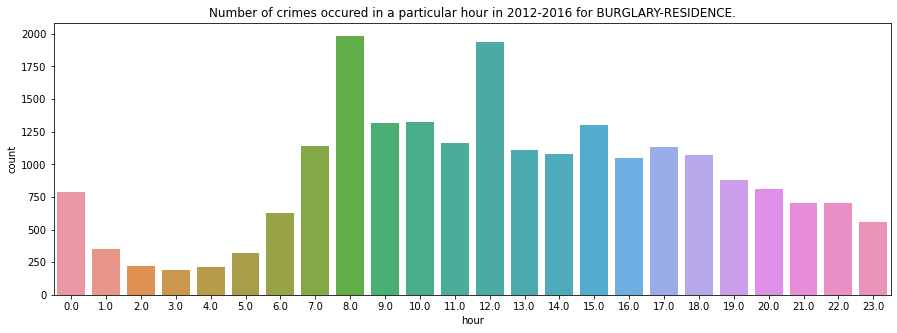

In [57]:
period_count(df_BR_time, 'hour', crime='BURGLARY-RESIDENCE', year='2012-2016')

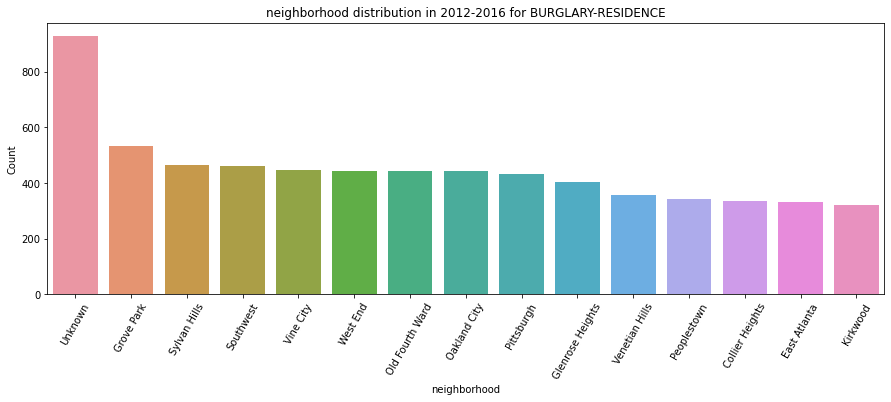

In [58]:
count_plot(df_BR, 'neighborhood', crime='BURGLARY-RESIDENCE')

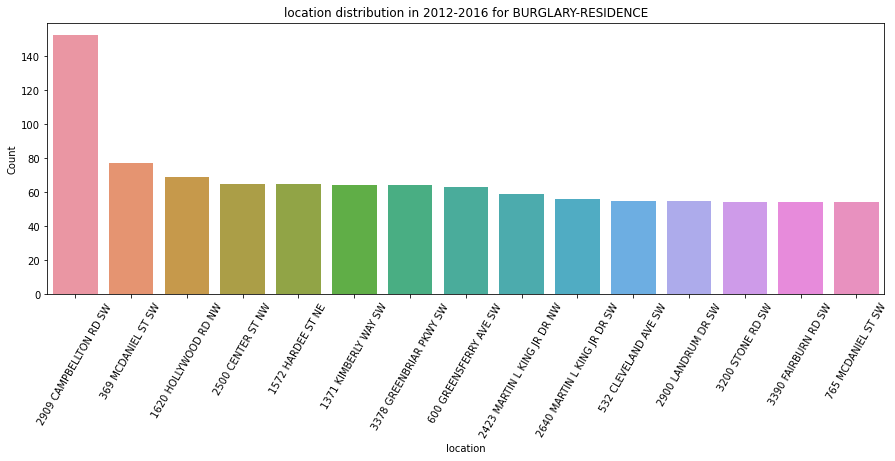

In [59]:
count_plot(df_BR, 'location', crime='BURGLARY-RESIDENCE')

##### BURGLARY-RESIDENCE
1. Case keeps decreasing from 2012 to 2016
2. Dangerous months are Dec. and Jan.
3. Dangerous time are 7AM to 6PM in the day, especially 8AM and 12PM. Also need to be careful at 0AM
4. Dangerous neighborhoods are Grove Park, Sylvan Hills, Southwest
5. Dangerous locations are 2909 CAMPBELLTON RD SW, 369 MCDANIEL ST SW, 1620 HOLLYWOOD RD NW

#### 3.6.5 AUTO THEFT

In [60]:
df_AT = g_crime_type.get_group('AUTO THEFT')
df_AT_date = make_df_date(df_AT)
df_AT_time = make_df_time(df_AT)

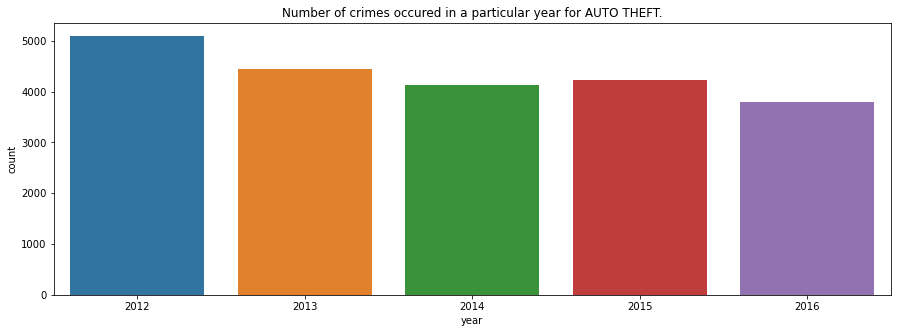

In [61]:
period_count(df_AT_date, 'year', crime='AUTO THEFT', order=range(2012,2017))

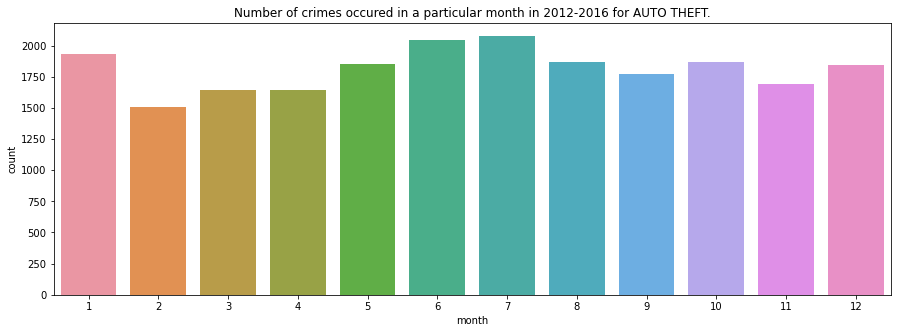

In [62]:
period_count(df_AT_date, 'month', crime='AUTO THEFT', year='2012-2016')

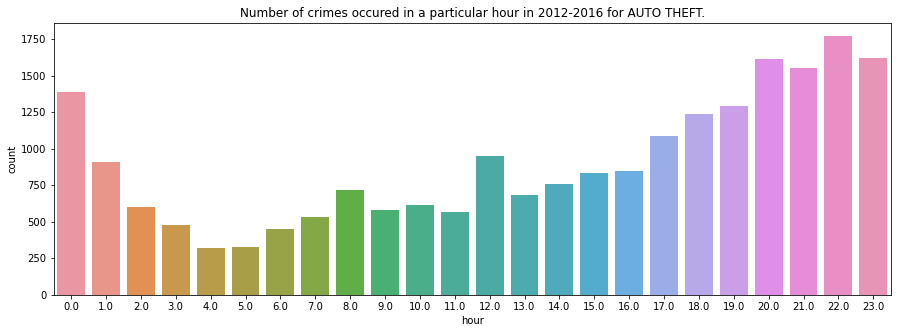

In [63]:
period_count(df_AT_time, 'hour', crime='AUTO THEFT', year='2012-2016')

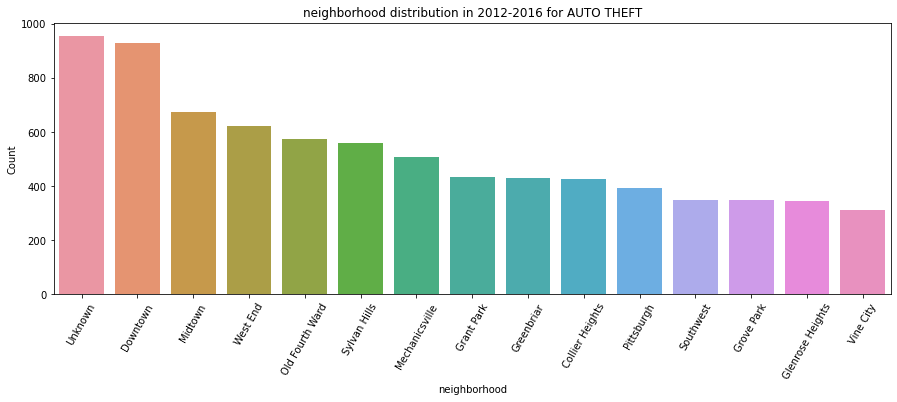

In [64]:
count_plot(df_AT, 'neighborhood', crime='AUTO THEFT')

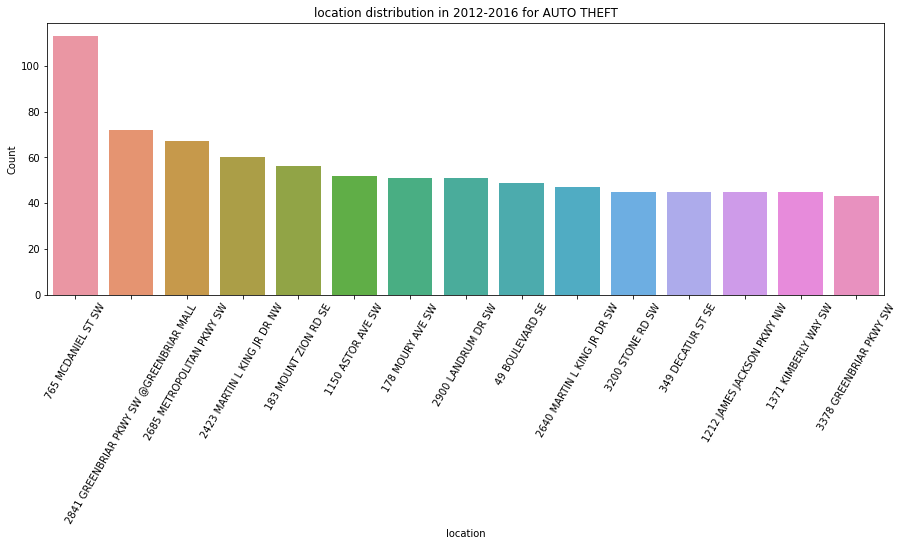

In [65]:
count_plot(df_AT, 'location', crime='AUTO THEFT')

##### AUTO THEFT
1. Case deeps deceasing from 2012 to 2016, with a slight increase in 2015
2. Dangerous months are Jan., June and July.
3. Dangerous time are 5PM to 1AM at night, especially 8PM and 10PM. Also need to be careful at 8AM and 12PM
4. Dangerous neighborhoods are Downtown, Midtown, West End, and some unknown area
5. Dangerous locations are 765 MCDANIEL ST SW, 2841 GREENBRIAR PKWY SW @GREENBRIAR MALL, 2685 METROPOLITAN PKWY SW

#### 3.6.6 AGG ASSAULT

In [66]:
df_AA = g_crime_type.get_group('AGG ASSAULT')
df_AA_date = make_df_date(df_AA)
df_AA_time = make_df_time(df_AA)

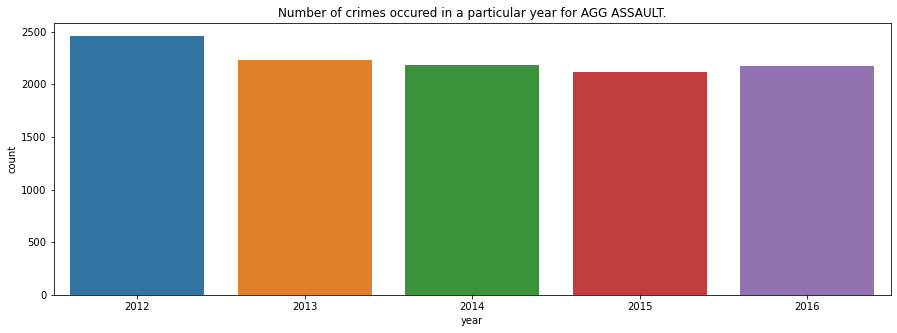

In [67]:
period_count(df_AA_date, 'year', crime='AGG ASSAULT', order=range(2012,2017))

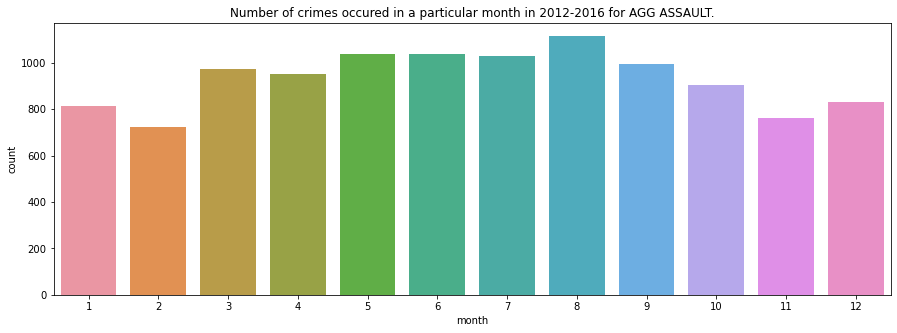

In [68]:
period_count(df_AA_date, 'month', crime='AGG ASSAULT', year='2012-2016')

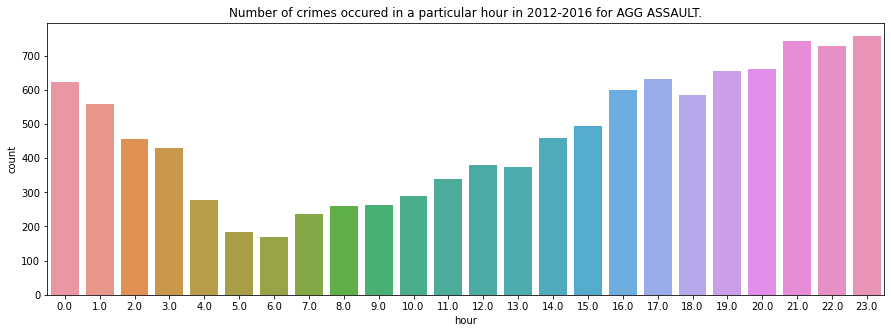

In [69]:
period_count(df_AA_time, 'hour', crime='AGG ASSAULT', year='2012-2016')

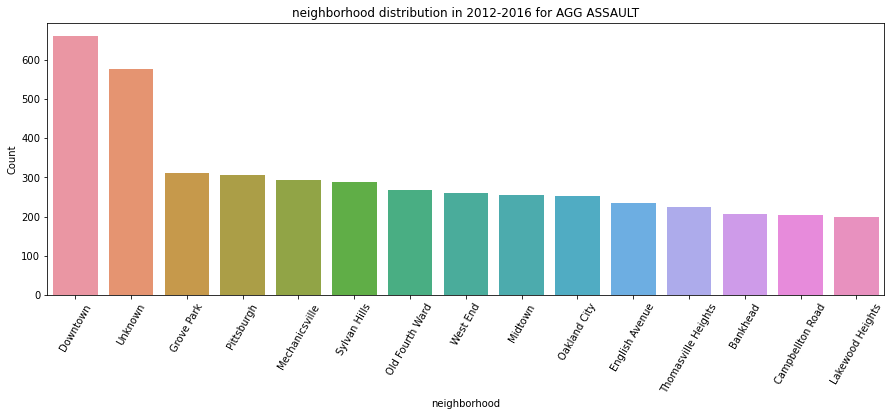

In [70]:
count_plot(df_AA, 'neighborhood', crime='AGG ASSAULT')

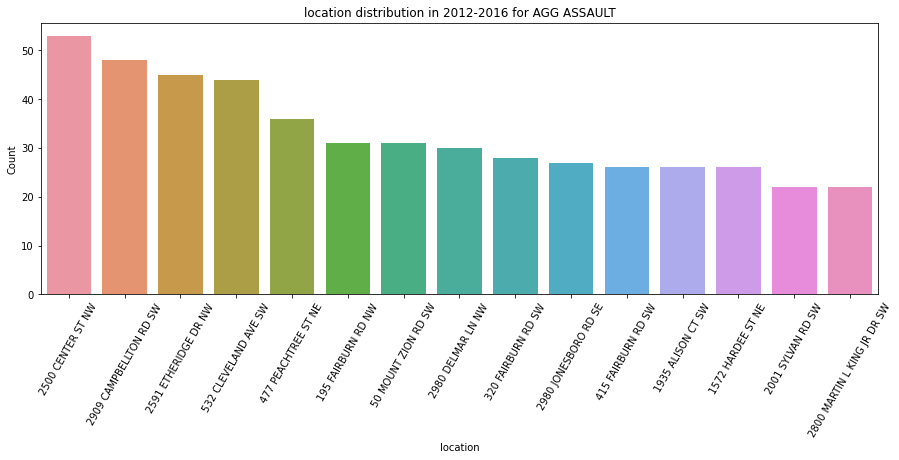

In [71]:
count_plot(df_AA, 'location', crime='AGG ASSAULT')

##### AGG ASSAULT
1. Case keeps decreasing from 2012 to 2015, with a slight increase in 2016
2. Dangerous months are May to Aug. (in the summer)
3. Dangerous time are 4PM to 1AM at night, especially 9PM and 11PM
4. Dangerous neighborhoods are Downtown, Grove Park, Pittsburgh
5. Dangerous locations are 2500 CENTER ST NW, 2909 CAMPBELLTON RD SW, 2591 ETHERIDGE DR NW

In [72]:
df_crime_type = label(df, 'UC2 Literal')
df_crime_type.head()

UC2 Literal
0            6
1            6
2            1
3            1
4            5

### 3.7 crime heatmap

##### First I will give a zoom controllable crime heatmap of all the crimes in 2012 to 2016

In [73]:
alt_loc = [33.7490, -84.3880]
base_map = folium.Map(location=alt_loc, zoom_start=11)
heatmap = plugins.HeatMap(df[['y', 'x']], radius=3, blur=6)
base_map.add_child(heatmap)

In [74]:
# helper function to stack the heatmap of different crime types
def heat_maps(df, fea='UC2 Literal'):
    fig = plt.figure(figsize=(15,15))
    ctypes = df[fea].value_counts().index
    for i, crime_type in enumerate(ctypes):
        ax = fig.add_subplot(int(np.ceil(float(len(ctypes)) / 4)), 4, i+1)
        crime_df = df.groupby(fea).get_group(crime_type)
        sns.regplot('x', 'y', data=crime_df[['x','y']], fit_reg=False, scatter_kws={'alpha':0.5, 'color':'grey'}, ax=ax)
        sns.kdeplot(X='x', Y='y', data=crime_df[['x','y']], cmap="jet", bw=.003, cbar=True, shade=True, 
                    shade_lowest=False, ax = ax)
        ax.set_title(crime_type)
        ax.set_axis_off()
    plt.show()

##### Next I will show crime heatmaps for different years and different crime types. The gray area shows all the crimes of a certain type and the jet color area highlights the high risk area.

#### 3.7.1 2012

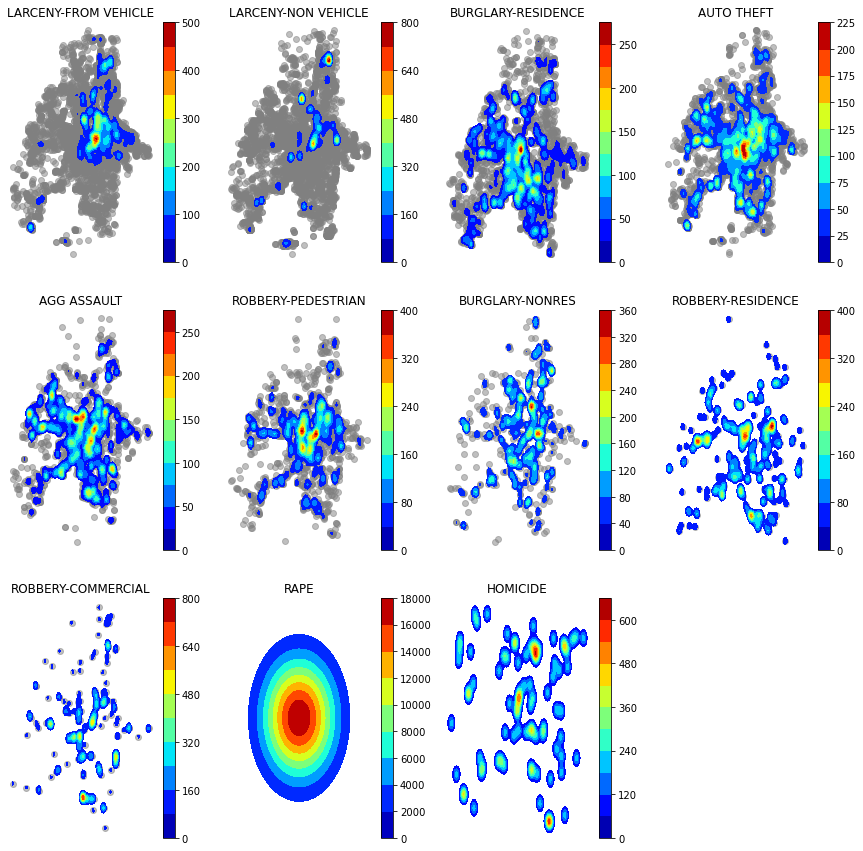

In [75]:
heat_maps(df2012)

In [76]:
g_crime = df.groupby('UC2 Literal')
df_rape = g_crime.get_group('RAPE')
df_rape[['y', 'x']].value_counts()

y    x  
0.0  0.0    671
dtype: int64

##### The coordinate (x, y) of RAPE crime is not correctly recorded. They are just (0, 0) in the dataframe.

In [77]:
# helper function to stack the heatmap of all crimes, excluding RAPE
def heat_map_all(df, fea='UC2 Literal'):
    fig = plt.figure(figsize=(12,12))
    crime_df = df[df[fea] != 'RAPE']
    sns.regplot('x', 'y', data=crime_df[['x','y']], fit_reg=False, scatter_kws={'alpha':0.5, 'color':'grey'})
    sns.kdeplot(X='x', Y='y', data=crime_df[['x','y']], cmap="jet", bw=.003, cbar=True, shade=True, shade_lowest=False)
    plt.show()

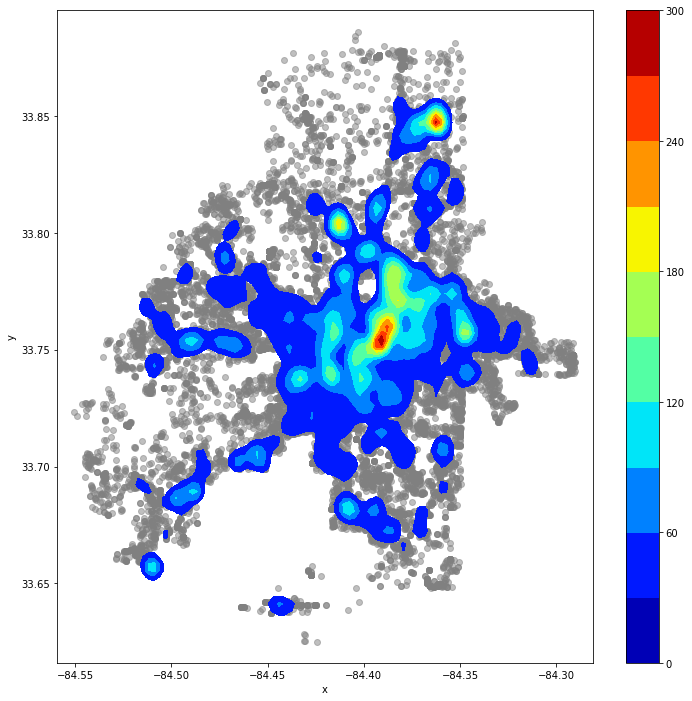

In [78]:
heat_map_all(df2012)

#### 3.7.2 2013

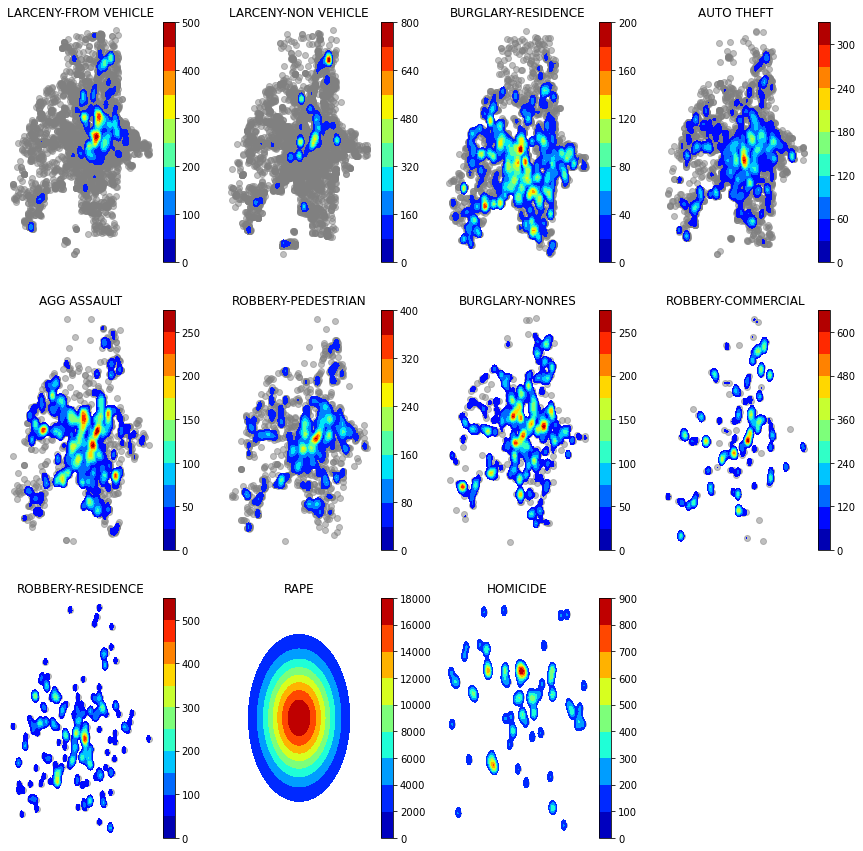

In [79]:
heat_maps(df2013)

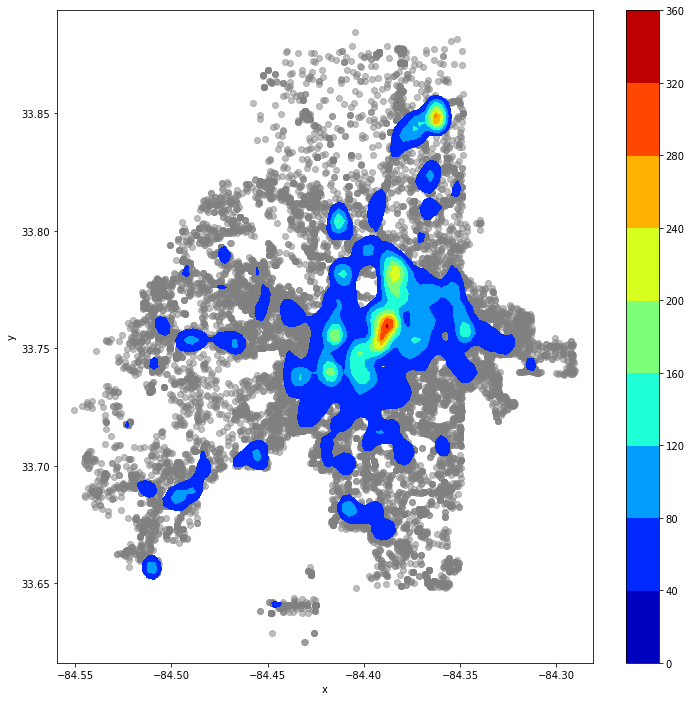

In [80]:
heat_map_all(df2013)

#### 3.7.3 2014

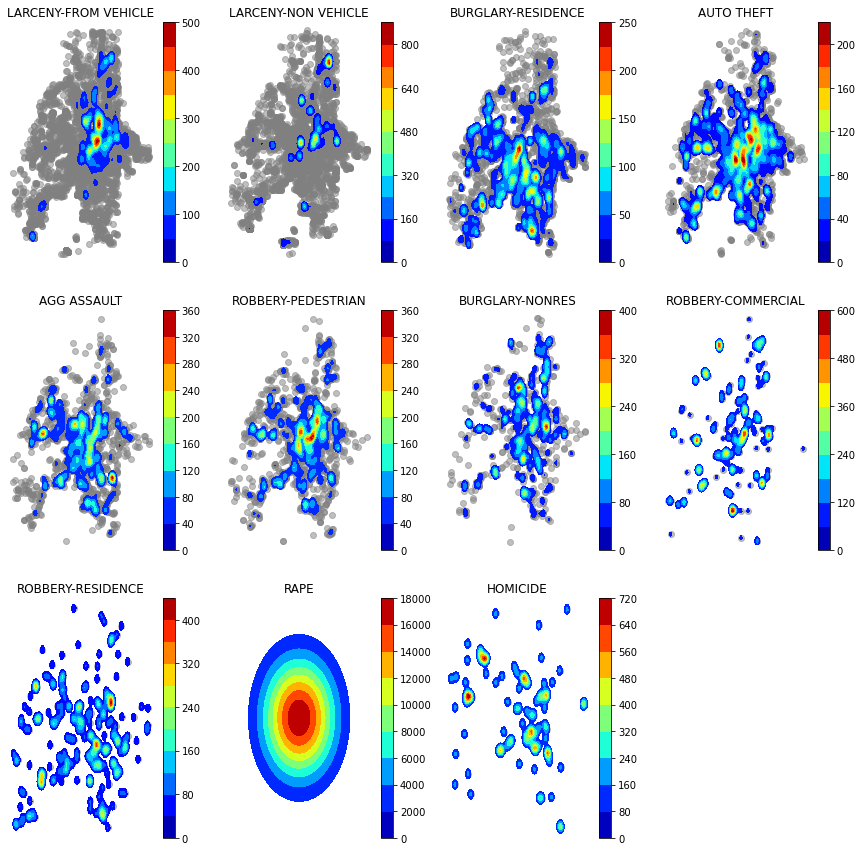

In [81]:
heat_maps(df2014)

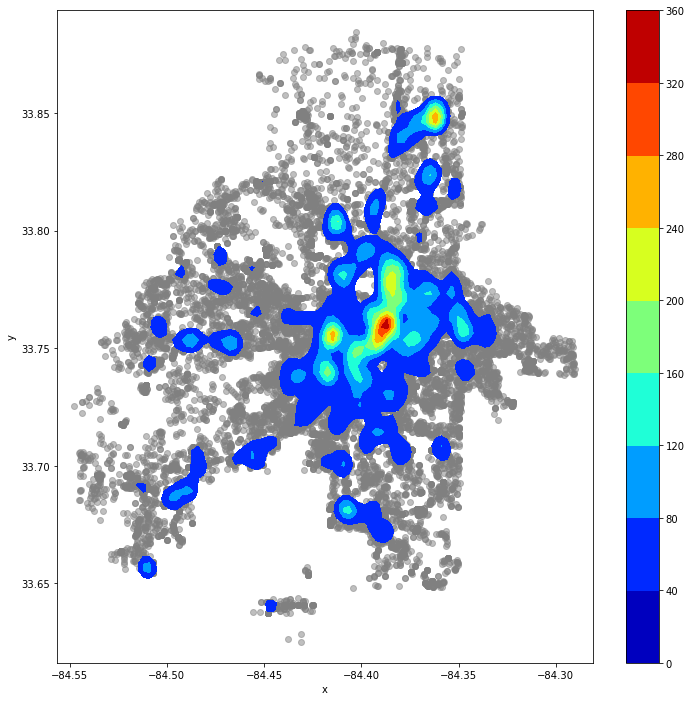

In [82]:
heat_map_all(df2014)

#### 3.7.4 2015

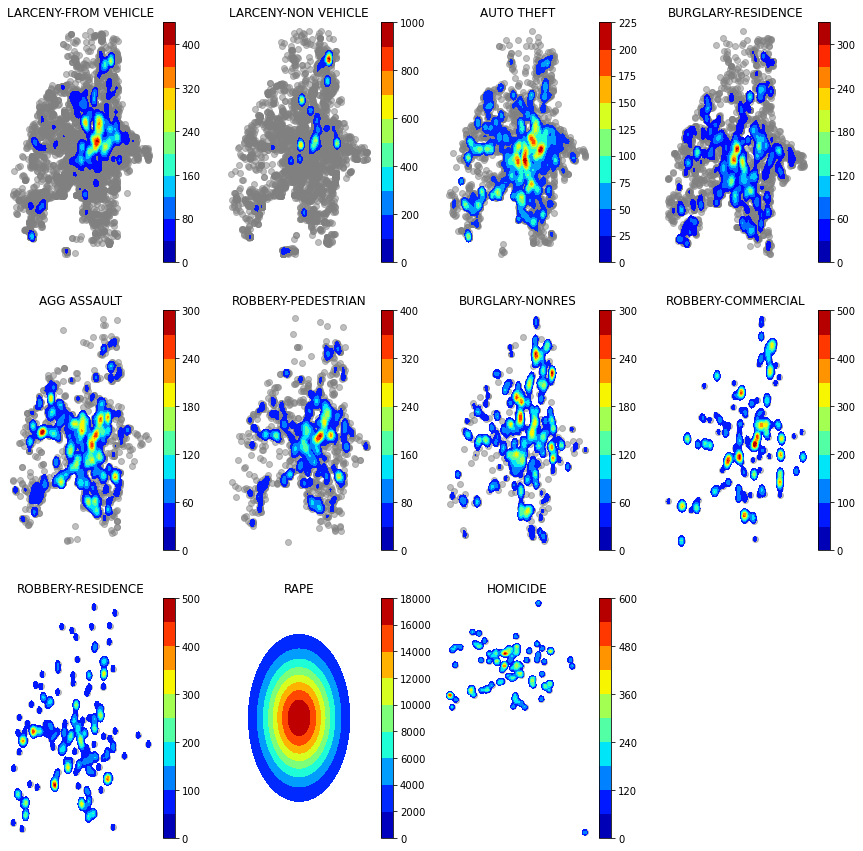

In [83]:
heat_maps(df2015)

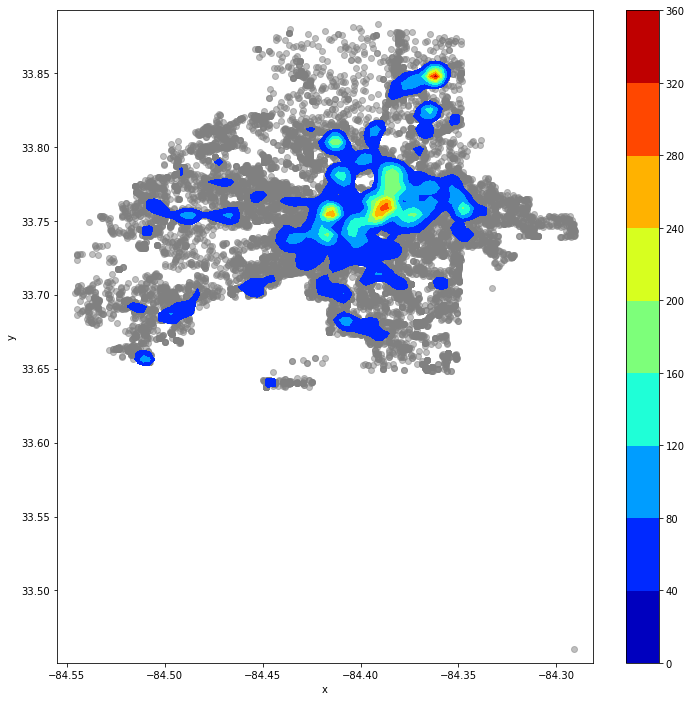

In [84]:
heat_map_all(df2015)

##### There is one point ('HOMICIDE') far away from the main Atlanta city area, could be some mislabel

#### 3.7.5 2016

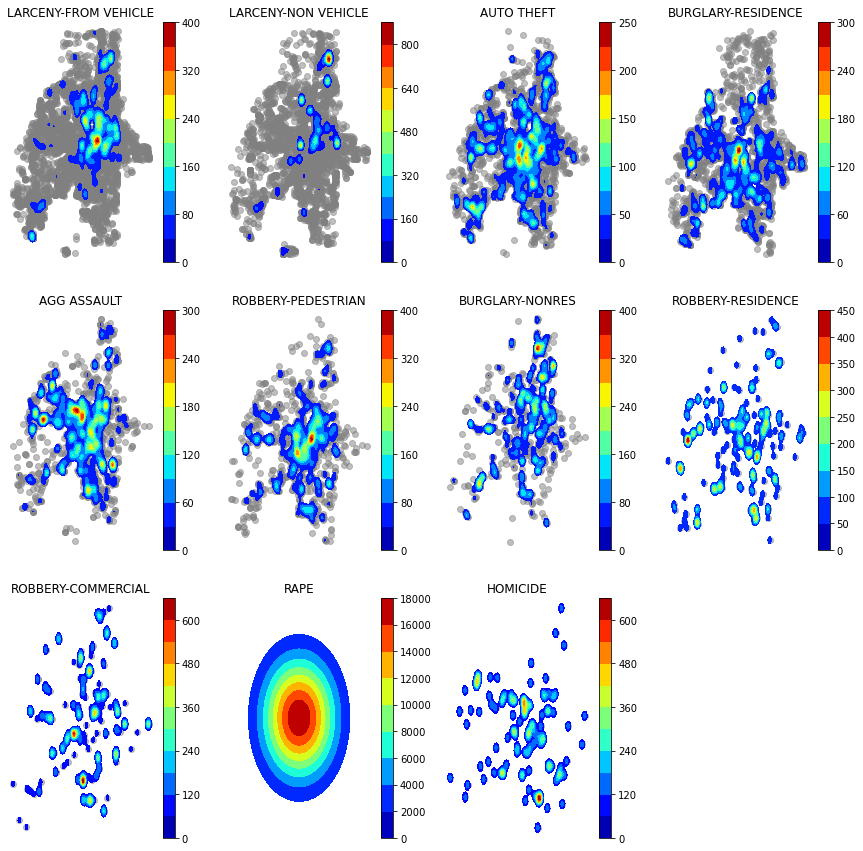

In [85]:
heat_maps(df2016)

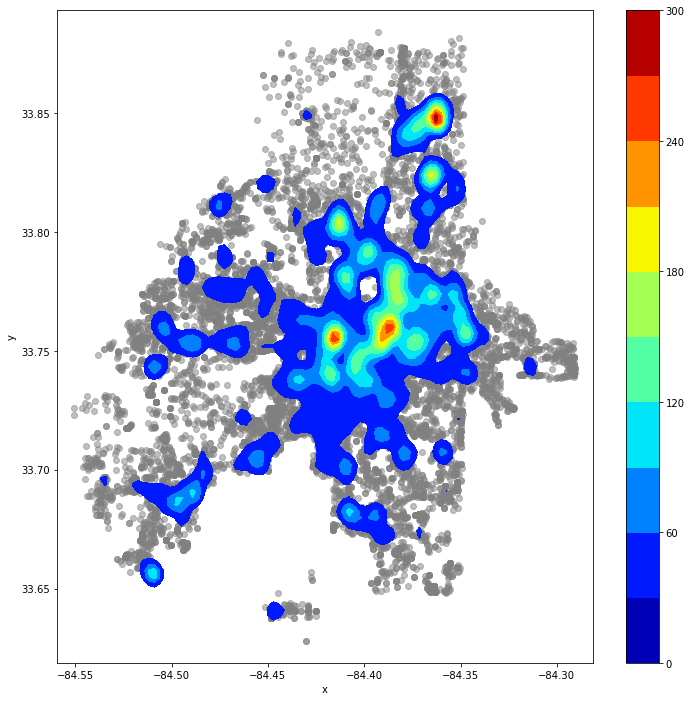

In [86]:
heat_map_all(df2016)

## 4. Modeling

##### I will build 3 different models 
1. XGBoost with engineered features
2. LSTM with time series data
3. Naive Linear Regression

### 4.1 XGBoost

#### 4.1.1 Data Preparation

##### Combine df_date_period, df_time_period, df_shift, df_neighborhood, df_location, df_crime_type, and  x, y as the final dataframe

In [87]:
my_dfs = [df_date_period, df_time_period, df_shift, df_neighborhood, df_location, df_crime_type, df[['x', 'y']]]
xgb_df = pd.concat(my_dfs, axis=1)
xgb_df = xgb_df[xgb_df['year']>=2012].reset_index(drop=True)
xgb_df = xgb_df.sort_values('date').reset_index(drop=True)

In [88]:
xgb_df.head()

date  year  month  day  weekday  sin_month  cos_month   sin_day  \
0 2012-01-01  2012      1    1        7        0.5   0.866025  0.201299   
1 2012-01-01  2012      1    1        7        0.5   0.866025  0.201299   
2 2012-01-01  2012      1    1        7        0.5   0.866025  0.201299   
3 2012-01-01  2012      1    1        7        0.5   0.866025  0.201299   
4 2012-01-01  2012      1    1        7        0.5   0.866025  0.201299   

   cos_day   sin_weekday  cos_weekday  hour  min_in_day       sin_min  \
0  0.97953 -2.449294e-16          1.0  19.0      1170.0 -9.238795e-01   
1  0.97953 -2.449294e-16          1.0  23.0      1380.0 -2.588190e-01   
2  0.97953 -2.449294e-16          1.0  12.0       720.0  1.224647e-16   
3  0.97953 -2.449294e-16          1.0  22.0      1320.0 -5.000000e-01   
4  0.97953 -2.449294e-16          1.0  20.0      1200.0 -8.660254e-01   

    cos_min  Shift  neighborhood  location  UC2 Literal         x         y  
0  0.382683      2           171     35503            5 -84.37563  33.82010  
1  0.965926      2           110     19827            1 -84.47335  33.74894  
2 -1.000000      3            74     17688            5 -84.39446  33.81347  
3  0.866025      2           107     49214            1 -84.44642  33.77694  
4  0.500000      2           175     39271            6 -84.40776  33.68559

In [89]:
xgb_df.shape

(155787, 21)

##### Build the target: number of crimes in that year

In [90]:
temp_df = df_date[df_date['year'] >= 2012][['year']]
temp_df['crimes'] = 1
temp_df.groupby('year').sum()

crimes
year        
2012   33352
2013   32252
2014   31159
2015   30092
2016   28932

In [91]:
check = {2012: 33352, 2013: 32252, 2014: 31159, 2015: 30092, 2016: 28932}
y = np.array([check[year] for year in xgb_df['year']])
y.shape

(155787,)

#### 4.1.2 Train and Test Data

In [92]:
features = list(xgb_df.columns)
features.remove('date')
features.remove('year')

split = len(xgb_df[xgb_df['year'] < 2015])

train_y = np.asarray(y[:split])
train_X = xgb_df[features][:split]

test_y = np.asarray(y[split:])
test_X = xgb_df[features][split:]

#### 4.1.3 Model Building and Evaluation

In [93]:
model_xgb = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
model_xgb = model_xgb.fit(train_X, train_y)

In [94]:
train_y_pred_xgb = model_xgb.predict(train_X)
test_y_pred_xgb = model_xgb.predict(test_X)

In [95]:
# MSE for train and test data
print("Train MSE: {:.4f}".format(mean_squared_error(train_y_pred_xgb, train_y)))
print("Test MSE: {:.4f}".format(mean_squared_error(test_y_pred_xgb, test_y)))

Train MSE: 778846.1976
Test MSE: 7898469.9699


In [96]:
# R2 for train and test data
print("Train R2 score: {:.4f}".format(r2_score(train_y_pred_xgb, train_y)))
print("Test R2 score: {:.4f}".format(r2_score(test_y_pred_xgb, test_y)))

Train R2 score: -143.6285
Test R2 score: -973.8946


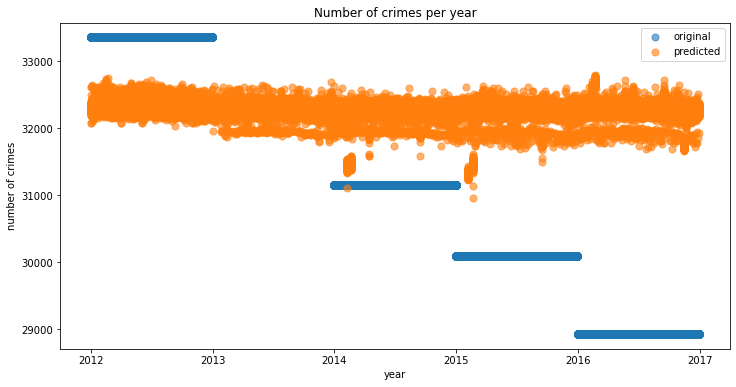

In [97]:
# visualization
plt.figure(figsize=(12,6))
plt.scatter(xgb_df['date'], y, s=50, alpha=0.6, label='original')
plt.scatter(xgb_df['date'], list(train_y_pred_xgb) + list(test_y_pred_xgb), s=50, alpha=0.6, label='predicted')
plt.xlabel('year')
plt.ylabel('number of crimes')
plt.legend(loc='best')
plt.title('Number of crimes per year')
plt.show()

##### The model is way from optimal. But due to lack of time, I skipped hyperparater tunning here. I will do tunning in question 2. Instead, I will try some other models here for better prediction.

### 4.2 LSTM

#### 4.2.1 Data Preparation

In [98]:
# build a dataframe with date as index and only feature is the number of crimes each day
dl_df = df_date[df_date['year'] >= 2012][['date']]
dl_df['crimes'] = 1
dl_df = dl_df.groupby('date').sum()
dl_df.head()

crimes
date              
2012-01-01      99
2012-01-02      92
2012-01-03      86
2012-01-04      88
2012-01-05      86

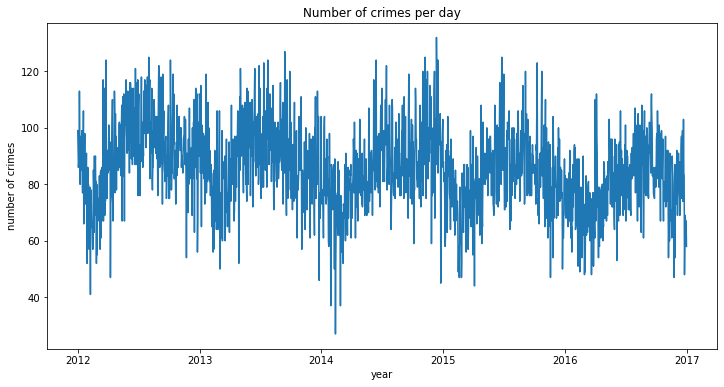

In [99]:
plt.figure(figsize=(12,6))
plt.plot(dl_df)
plt.xlabel('year')
plt.ylabel('number of crimes')
plt.title('Number of crimes per day')
plt.show()

In [100]:
# rescale the data for faster training
scaler = MinMaxScaler()
data_rescale = scaler.fit_transform(dl_df)
data_rescale = data_rescale.reshape(1,len(dl_df))[0]

#### 4.2.2 Train and Test Data

##### Feature building: because the number of crimes per day and per month both show some seasonal behavior,  I will use the number of crimes in the first 31 days (about one month) to predict the number of crimes in the next day

In [101]:
# build the final data frame with previous 31 days of data as X and next day data as Y
print(len(data_rescale))

y = [] # to be the number of crimes in a certain day 
x = [] # to be the number of crimes in the previous 31 days

for i in range(31, len(data_rescale)):
    y.append(data_rescale[i])
    x.append(data_rescale[i-31:i])
x = pd.DataFrame(x)
x = x.set_index(dl_df.index[31:])
print(x.shape)

1827
(1796, 31)


In [102]:
x.head()

0         1         2         3         4         5  \
date                                                                     
2012-02-01  0.685714  0.619048  0.561905  0.580952  0.561905  0.819048   
2012-02-02  0.619048  0.561905  0.580952  0.561905  0.819048  0.676190   
2012-02-03  0.561905  0.580952  0.561905  0.819048  0.676190  0.504762   
2012-02-04  0.580952  0.561905  0.819048  0.676190  0.504762  0.609524   
2012-02-05  0.561905  0.819048  0.676190  0.504762  0.609524  0.657143   

                   6         7         8         9        10        11  \
date                                                                     
2012-02-01  0.676190  0.504762  0.609524  0.657143  0.666667  0.552381   
2012-02-02  0.504762  0.609524  0.657143  0.666667  0.552381  0.685714   
2012-02-03  0.609524  0.657143  0.666667  0.552381  0.685714  0.561905   
2012-02-04  0.657143  0.666667  0.552381  0.685714  0.561905  0.476190   
2012-02-05  0.666667  0.552381  0.685714  0.561905  0.476190  0.476190   

                  12        13        14        15        16        17  \
date                                                                     
2012-02-01  0.685714  0.561905  0.476190  0.476190  0.628571  0.752381   
2012-02-02  0.561905  0.476190  0.476190  0.628571  0.752381  0.371429   
2012-02-03  0.476190  0.476190  0.628571  0.752381  0.371429  0.600000   
2012-02-04  0.476190  0.628571  0.752381  0.371429  0.600000  0.590476   
2012-02-05  0.628571  0.752381  0.371429  0.600000  0.590476  0.676190   

                  18        19        20        21        22        23  \
date                                                                     
2012-02-01  0.371429  0.600000  0.590476  0.676190  0.495238  0.523810   
2012-02-02  0.600000  0.590476  0.676190  0.495238  0.523810  0.438095   
2012-02-03  0.590476  0.676190  0.495238  0.523810  0.438095  0.542857   
2012-02-04  0.676190  0.495238  0.523810  0.438095  0.542857  0.609524   
2012-02-05  0.495238  0.523810  0.438095  0.542857  0.609524  0.428571   

                  24        25        26        27        28        29  \
date                                                                     
2012-02-01  0.438095  0.542857  0.609524  0.428571  0.238095  0.438095   
2012-02-02  0.542857  0.609524  0.428571  0.238095  0.438095  0.561905   
2012-02-03  0.609524  0.428571  0.238095  0.438095  0.561905  0.476190   
2012-02-04  0.428571  0.238095  0.438095  0.561905  0.476190  0.504762   
2012-02-05  0.238095  0.438095  0.561905  0.476190  0.504762  0.409524   

                  30  
date                  
2012-02-01  0.561905  
2012-02-02  0.476190  
2012-02-03  0.504762  
2012-02-04  0.409524  
2012-02-05  0.285714

In [103]:
# split the train (2012-2014) and test (2015-2016) data
split = len(x[x.index < '2015'])

train_y = np.asarray(y[:split])
train_X = x[:split].values

test_y = np.asarray(y[split:])
test_X = x[split:].values

In [104]:
# check the data shape
print(train_X.shape, len(train_y), test_X.shape, len(test_y))

(1065, 31) 1065 (731, 31) 731


#### 4.2.3 Model Building

In [105]:
# reshape to the format of HWC
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1],1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [106]:
# build a LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=train_X.shape[1:]))
model.add(Dropout(0.4))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(units=50))
model.add(Dropout(0.4))
model.add(Dense(units=1))
model.compile(optimizer='rmsprop', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 31, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 31, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 31, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 31, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [107]:
# training
out = model.fit(train_X, train_y, epochs=100, batch_size=32)

Epoch 1/100
34/34 [==============================] - 2s 55ms/step - loss: 0.0540
Epoch 2/100
34/34 [==============================] - 2s 52ms/step - loss: 0.0334
Epoch 3/100
34/34 [==============================] - 2s 53ms/step - loss: 0.0295: 0s
Epoch 4/100
34/34 [==============================] - 2s 50ms/step - loss: 0.0293
Epoch 5/100
34/34 [==============================] - 2s 50ms/step - loss: 0.0276
Epoch 6/100
34/34 [==============================] - 2s 51ms/step - loss: 0.0259
Epoch 7/100
34/34 [==============================] - 2s 51ms/step - loss: 0.0253
Epoch 8/100
34/34 [==============================] - 2s 50ms/step - loss: 0.0253
Epoch 9/100
34/34 [==============================] - 2s 47ms/step - loss: 0.0236
Epoch 10/100
34/34 [==============================] - 2s 47ms/step - loss: 0.0244
Epoch 11/100
34/34 [==============================] - 2s 51ms/step - loss: 0.0218
Epoch 12/100
34/34 [==============================] - 2s 51ms/step - loss: 0.0222
Epoch 13/100
34/34 [=

#### 4.2.4 Model Evaluation

In [108]:
train_y_predict = model.predict(train_X)
test_y_predict = model.predict(test_X)

##### Here I choose mean squared error (MSE) as the metric for this regression-like problem

In [109]:
# MSE for train and test data
print("Train MSE: {:.4f}".format(mean_squared_error(train_y_predict, train_y)))
print("Test MSE: {:.4f}".format(mean_squared_error(test_y_predict, test_y)))

Train MSE: 0.0158
Test MSE: 0.0141


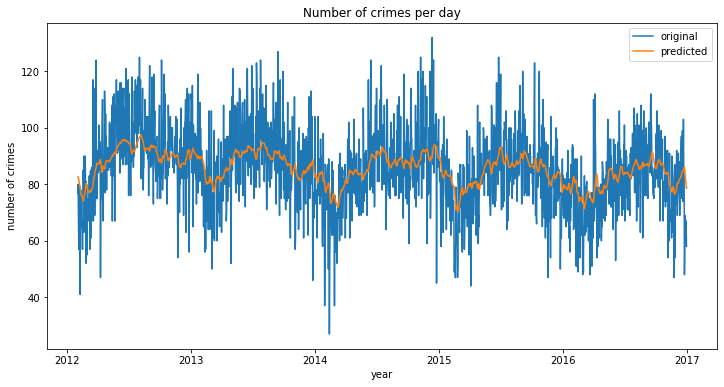

In [110]:
# visualize the prediction

predict = np.concatenate((scaler.inverse_transform(train_y_predict), scaler.inverse_transform(test_y_predict)), axis = 0)
output = pd.DataFrame(index=dl_df.index[31:])
output['original'] = scaler.inverse_transform(np.array(y).reshape(1, -1))[0]
output['predicted'] = np.reshape(predict, (1, -1))[0]

plt.figure(figsize=(12,6))
plt.plot(output['original'], label='original')
plt.plot(output['predicted'], label='predicted')
plt.xlabel('year')
plt.ylabel('number of crimes')
plt.legend(loc='best')
plt.title('Number of crimes per day')
plt.show()

In [111]:
# number of crimes per year
eva_df_dl = output.resample('Y').sum()
eva_df_dl['difference (%)'] = 100 * (eva_df_dl['predicted'] - eva_df_dl['original'])/eva_df_dl['original']
eva_df_dl

original     predicted  difference (%)
date                                              
2012-12-31   30668.0  29828.632812       -2.736948
2013-12-31   32252.0  32007.636719       -0.757669
2014-12-31   31159.0  31241.644531        0.265235
2015-12-31   30092.0  30754.644531        2.202062
2016-12-31   28932.0  30011.039062        3.729570

##### P.S. This model actually requies the existing data in 2015-2016 to make the prediction. It's in fact using 31 days date to predict the next day.

### 4.3 Naive Linear Regression

##### The yearly distribution of number of crimes per year show some linear decreasing behavior, thus a simple linear regression may be good.

In [112]:
df_year = dl_df.resample('Y').sum()
df_year

crimes
date              
2012-12-31   33352
2013-12-31   32252
2014-12-31   31159
2015-12-31   30092
2016-12-31   28932

In [113]:
train_y = df_year['crimes'][:3]
train_X = np.array(range(2012, 2015)).reshape(-1,1)

test_y = df_year['crimes'][3:]
test_X = np.array(range(2015, 2017)).reshape(-1,1)

In [114]:
model_lr = LinearRegression()
model_lr.fit(train_X, train_y)
train_y_pred_lr = model_lr.predict(train_X)
test_y_pred_lr = model_lr.predict(test_X)

##### Here I use r2 score as the metric

In [115]:
# R2 for train and test data
print("Train R2 score: {:.10f}".format(r2_score(train_y_pred_lr, train_y)))
print("Test R2 score: {:.10f}".format(r2_score(test_y_pred_lr, test_y)))

Train R2 score: 0.9999966038
Test R2 score: 0.9966423494


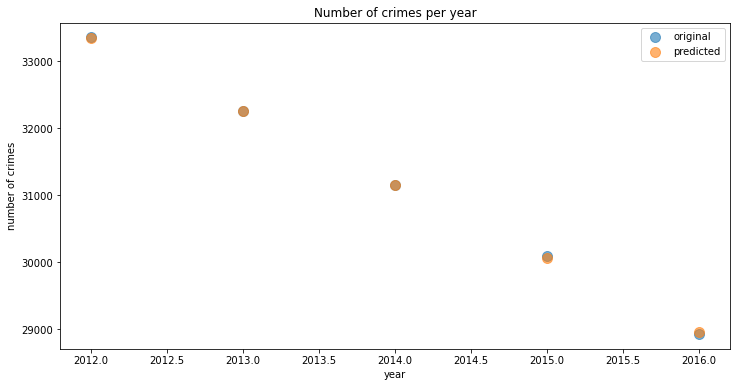

In [116]:
# visualization
plt.figure(figsize=(12,6))
plt.scatter(range(2012, 2017), df_year['crimes'], s=100, alpha=0.6, label='original')
plt.scatter(range(2012, 2017), list(train_y_pred_lr) + list(test_y_pred_lr), s=100, alpha=0.6, label='predicted')
plt.xlabel('year')
plt.ylabel('number of crimes')
plt.legend(loc='best')
plt.title('Number of crimes per year')
plt.show()

In [117]:
# number of crimes per year
data = {
    'original': df_year['crimes'].values,
    'predicted': list(train_y_pred_lr) + list(test_y_pred_lr)
}
eva_df_lr = pd.DataFrame(data=data, index=range(2012, 2017))
eva_df_lr['difference (%)'] = 100 * (eva_df_lr['predicted'] - eva_df_lr['original'])/eva_df_lr['original']
eva_df_lr

original     predicted  difference (%)
2012     33352  33350.833333       -0.003498
2013     32252  32254.333333        0.007235
2014     31159  31157.833333       -0.003744
2015     30092  30061.333333       -0.101910
2016     28932  28964.833333        0.113484

##### This oversimplified model gives great prediction. However, we can see it will be off in the long run.